In [ ]:
!pip install scienceplots

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import subprocess
import shutil
import time
# from nilearn import datasets
# from nilearn.image import load_img, index_img
# from nilearn.plotting import plot_epi
# from nilearn.maskers import NiftiLabelsMasker
from joblib import delayed, Parallel
import pandas as pd
from scipy import stats
from scipy.stats import zscore
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
from utils.data_loader import DataLoader, fl_to_vox
from scipy.stats import zscore
import glob
# from utils.relaxation_time import RelaxationTime
import scienceplots
import matplotlib as mpl
import warnings
import seaborn as sns
warnings.filterwarnings(action='ignore')
plt.style.use(['science','no-latex', 'ieee'])
plt.rcParams.update({
    "font.family": "DejaVu Sans",   # specify font family here
})

In [3]:
def reset_rc_params():
    plt.rcParams.update(plt.rcParamsDefault)
    plt.style.use(['science','no-latex', 'ieee'])
    plt.rcParams.update({
        "font.family": "DejaVu Sans",   # specify font family here
    })
    return

In [4]:
root_dir = '/scratch/shivansh.seth/adni/preproc'
SCRATCH_DATA_DIR = '/scratch/shivansh.seth/tmp/'
PRINT_TIME_INTERVAL = 20
if not os.path.exists(SCRATCH_DATA_DIR): os.makedirs(SCRATCH_DATA_DIR)

In [5]:
dloader = DataLoader(root_dir)
# subjects_list = dloader.subjects_list

In [6]:
rts_res_dir = '/home/shivansh.seth/phase_diagram_analysis/rts_results_both_new'
rts_fl = []
rts_fl_idx = []
for idx, sub in enumerate(dloader.subjects_list):
    for j in os.listdir(rts_res_dir):
        if sub in j:
            try:
                k = np.load(os.path.join(rts_res_dir, j))
#                 print(k.shape)
                rts_fl.append(os.path.join(rts_res_dir, j))
                rts_fl_idx.append(idx)
            except:
                print(sub)
#                 os.remove(os.path.join(rts_res_dir, j))

In [7]:
rts_results_f= np.memmap(
        os.path.join(SCRATCH_DATA_DIR, 'roi_rts.dat'), 
        dtype='float32', 
        mode='w+', 
        shape=(len(rts_fl), *dloader.get_func(0).shape[:-1], 7)
    )
# rts_fl = [idd for i in glob.glob('rts_results/*npy')]
# rts_fl = [ [ j for j in os.listdir(rts_res_dir) ][0]  ]


In [8]:
for idx, i in enumerate(rts_fl):
    rts = np.load(i)
    rts_results_f[idx] = rts
    del rts

In [9]:
skull_indices = np.load('skull_indices.npy')

rts_results = np.zeros_like(rts_results_f)
print(rts_results_f.shape)
rts_results[:, :, :, :, :] = np.nan
rts_results[:, skull_indices[0], skull_indices[1], skull_indices[2], :]= rts_results_f[:, skull_indices[0], skull_indices[1], skull_indices[2], :]

(89, 51, 67, 67, 7)


In [10]:
og_shape = rts_results.shape
rts_results_flat = rts_results.reshape(og_shape[0], -1, 7)

In [11]:
inf_idx = np.where(np.isnan(rts_results[:, :, :, :, 3]))
inf_subjects = np.unique(inf_idx[0])
inf_count = len(np.where(np.isnan(rts_results[:, :, :, :, 0]))[0])
print(f"Percentage of voxels where fit fails: {100*inf_count/(rts_results_flat.shape[0]*rts_results_flat.shape[1]): .2f} %")

Percentage of voxels where fit fails:  86.21 %


In [12]:
rts_taus = rts_results_flat[:, :, 0]
rts_betas = rts_results_flat[:, :, 1]
rts_taus_exp = rts_results_flat[:, :, 2]

In [13]:
# dloader.diag = np.array(dloader.diag)
# np.random.shuffle(dloader.diag)

In [14]:
ad_betas = np.array([ rts_betas[i] for i in range(rts_betas.shape[0]) if dloader.diag[rts_fl_idx[i]] == 1 ])
cn_betas = np.array([ rts_betas[i] for i in range(rts_betas.shape[0]) if dloader.diag[rts_fl_idx[i]] == 0 ])
ad_taus = np.array([ rts_taus[i] for i in range(rts_taus.shape[0]) if dloader.diag[rts_fl_idx[i]] == 1 ])
cn_taus = np.array([ rts_taus[i] for i in range(rts_taus.shape[0]) if dloader.diag[rts_fl_idx[i]] == 0 ])
ad_taus_exp = np.array([ rts_taus[i] for i in range(rts_taus_exp.shape[0]) if dloader.diag[rts_fl_idx[i]] == 1 ])
cn_taus_exp = np.array([ rts_taus[i] for i in range(rts_taus_exp.shape[0]) if dloader.diag[rts_fl_idx[i]] == 0 ])

In [15]:
sk = np.load('skull_indices_flat.npy')
ad_betas = ad_betas[:, sk]
cn_betas = cn_betas[:, sk]
ad_taus = ad_taus[:, sk]
cn_taus = cn_taus[:, sk]

In [16]:
# Just flattening

# ad_betas_mean, cn_betas_mean = ad_betas.flatten(), cn_betas.flatten()
# ad_taus_mean, cn_taus_mean = ad_taus.flatten(), cn_taus.flatten()
# ad_taus_exp_mean, cn_taus_exp_mean = np.nanmean(ad_taus, axis=0), np.nanmean(cn_taus, axis=0)

# ad_taus_mean.shape, cn_taus_mean.shape

In [17]:
# Actual means

ad_betas_mean, cn_betas_mean = np.nanmean(ad_betas, axis=0), np.nanmean(cn_betas, axis=0)
ad_taus_mean, cn_taus_mean = np.nanmean(ad_taus, axis=0), np.nanmean(cn_taus, axis=0)
ad_taus_exp_mean, cn_taus_exp_mean = np.nanmean(ad_taus, axis=0), np.nanmean(cn_taus, axis=0)

ad_taus_mean.shape, cn_taus_mean.shape

((31569,), (31569,))

In [18]:
rts_betas_mean = np.nanmean(rts_betas,axis=0)

In [19]:
ad_taus_nonans = ad_taus
ad_taus_nonans = ad_taus_nonans[~np.isnan(ad_taus_nonans)]

cn_taus_nonans = cn_taus
cn_taus_nonans = cn_taus_nonans[~np.isnan(cn_taus_nonans)]

In [20]:
indices = np.random.permutation(len(rts_taus))
split_idx = len(indices)//2
print(indices)
spl1_taus = rts_taus[indices[:split_idx]]
spl2_taus = rts_taus[indices[split_idx:]] 
spl1_betas = rts_betas[indices[:split_idx]]
spl2_betas = rts_betas[indices[split_idx:]]
spl1_betas_mean = np.nanmean(spl1_betas, axis=0)
spl2_betas_mean = np.nanmean(spl2_betas, axis=0)

[86 48 49 70 31  1 29 19 84 11 60 12 26 76 46 43  7 68 66  8 85  4 23 36
 65 54  6 25 34 72  5 83 10 53  0 62 67 75 56 37 50 44 71 52 64 40 81  2
 59 16 28 27 63 79 88 35 14 15  9 78 58 30 82 33 87 41 69 38 24 20 80 17
 13 21 22 45 39 74 57 32 73 42 51 47 18 77  3 61 55]


In [21]:
def get_accepted_ranges(rrts):
    accepted_ranges = []
    for roi_ind in range(rrts.shape[1]):
        q1, q3 = np.nanpercentile(rrts[:, roi_ind], [25, 75])

        # Calculate IQR
        iqr = q3 - q1

        # Calculate lower and upper bounds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        accepted_ranges.append((lower_bound, upper_bound))
    accepted_ranges = np.array(accepted_ranges)

    return accepted_ranges

def get_outliers(rrts, accepted_ranges, sub_idxs=None):
    outliers = []
    for i in range(rrts.shape[1]):
        rejected_subs = np.where( (rrts[:, i] < accepted_ranges[i][0]) | (rrts[:, i] > accepted_ranges[i][1]) )[0]
        nan_subs = np.where(np.isnan(rrts[:, i]))[0]
        outliers.append(list(set(list(rejected_subs) + list(nan_subs))))
    
    # Popping elements not included in subject list without 
    # disturbing original indices
    if not (type(sub_idxs) == type(None)):
        for roi_ind in range(len(outliers)):
            non_sub_idx_outliers = []
            outliers[roi_ind] = list(outliers[roi_ind])

            for i in range(len(outliers[roi_ind])):
                if outliers[roi_ind][i] not in sub_idxs:
                    non_sub_idx_outliers.append(i)
            for i in sorted(non_sub_idx_outliers, reverse=True):
                del outliers[roi_ind][i]

    return outliers

In [22]:
stats.ttest_ind(ad_betas_mean[~np.isnan(ad_betas_mean)], cn_betas_mean[~np.isnan(cn_betas_mean)])

Ttest_indResult(statistic=9.18060181383214, pvalue=4.411999854177069e-20)

In [23]:
ad_taus_mean[~np.isnan(ad_taus_mean)].shape, cn_taus_mean[~np.isnan(cn_taus_mean)].shape

((31569,), (31569,))

In [24]:
print("Means: ", np.nanmean(ad_taus), np.nanmean(cn_taus))
print("STD: ", np.nanstd(ad_taus), np.nanstd(cn_taus))
print("Medians: ", np.nanmedian(ad_taus), np.nanmedian(cn_taus))

Means:  9.161558 11.438308
STD:  8.642783 10.805153
Medians:  5.829799 7.549398


In [25]:
print("Means: ", np.nanmean(ad_taus_mean), np.nanmean(cn_taus_mean))
print("STD: ", np.nanstd(ad_taus_mean), np.nanstd(cn_taus_mean))
print("Medians: ", np.nanmedian(ad_taus_mean), np.nanmedian(cn_taus_mean))

Means:  9.161555 11.43831
STD:  2.5519 3.0644243
Medians:  9.221259 11.599101


In [26]:
stats.ttest_ind(ad_taus_nonans.flatten(), cn_taus_nonans.flatten())

Ttest_indResult(statistic=-184.7918640284445, pvalue=0.0)

In [27]:
stats.ttest_ind(ad_taus_mean, cn_taus_mean)

Ttest_indResult(statistic=-101.43823810906092, pvalue=0.0)

In [28]:
cn_ar = get_accepted_ranges(cn_taus)
ad_ar = get_accepted_ranges(ad_taus)
cn_outliers = get_outliers(cn_taus, cn_ar)
ad_outliers = get_outliers(ad_taus, ad_ar)

In [29]:
all_cn_taus, all_ad_taus = [], []
for r in range(cn_taus.shape[1]):
    spl1_accepted_subs = list(set(range(len(cn_taus))).difference(cn_outliers[r]))
    spl2_accepted_subs = list(set(range(len(ad_taus))).difference(ad_outliers[r]))


    split1 = cn_taus[spl1_accepted_subs, r]
    split2 = ad_taus[spl2_accepted_subs, r]
#     print(split1.shape)
    all_cn_taus.extend(split1)    
    all_ad_taus.extend(split2)
all_ad_taus = np.array(all_ad_taus)
all_cn_taus = np.array(all_cn_taus)
all_ad_taus.shape, all_cn_taus.shape

((1043720,), (1695556,))

In [30]:
print("betas_mean")
print("mean:\t", np.nanmean(ad_betas_mean), np.nanmean(cn_betas_mean))
print("median:\t", np.nanmedian(ad_betas_mean), np.nanmedian(cn_betas_mean))
print("std:\t", np.nanstd(ad_betas_mean), np.nanstd(cn_betas_mean))

betas_mean
mean:	 0.74911505 0.74394083
median:	 0.7540053 0.74775577
std:	 0.07020647 0.071404435


In [31]:
print("taus_mean")
print("mean:\t", np.nanmean(ad_taus_mean*3), np.nanmean(cn_taus_mean*3))
print("median:\t", np.nanmedian(ad_taus_mean*3), np.nanmedian(cn_taus_mean*3))
print("std:\t", np.nanstd(ad_taus_mean*3), np.nanstd(cn_taus_mean*3))

taus_mean
mean:	 27.484665 34.31493
median:	 27.663776 34.797302
std:	 7.6556997 9.193273


In [32]:
print("taus")
print("mean:\t", np.nanmean(ad_taus*3), np.nanmean(cn_taus*3))
print("median:\t", np.nanmedian(ad_taus*3), np.nanmedian(cn_taus*3))
print("std:\t", np.nanstd(ad_taus*3), np.nanstd(cn_taus*3))

taus
mean:	 27.48468 34.314934
median:	 17.489397 22.648193
std:	 25.928354 32.41546


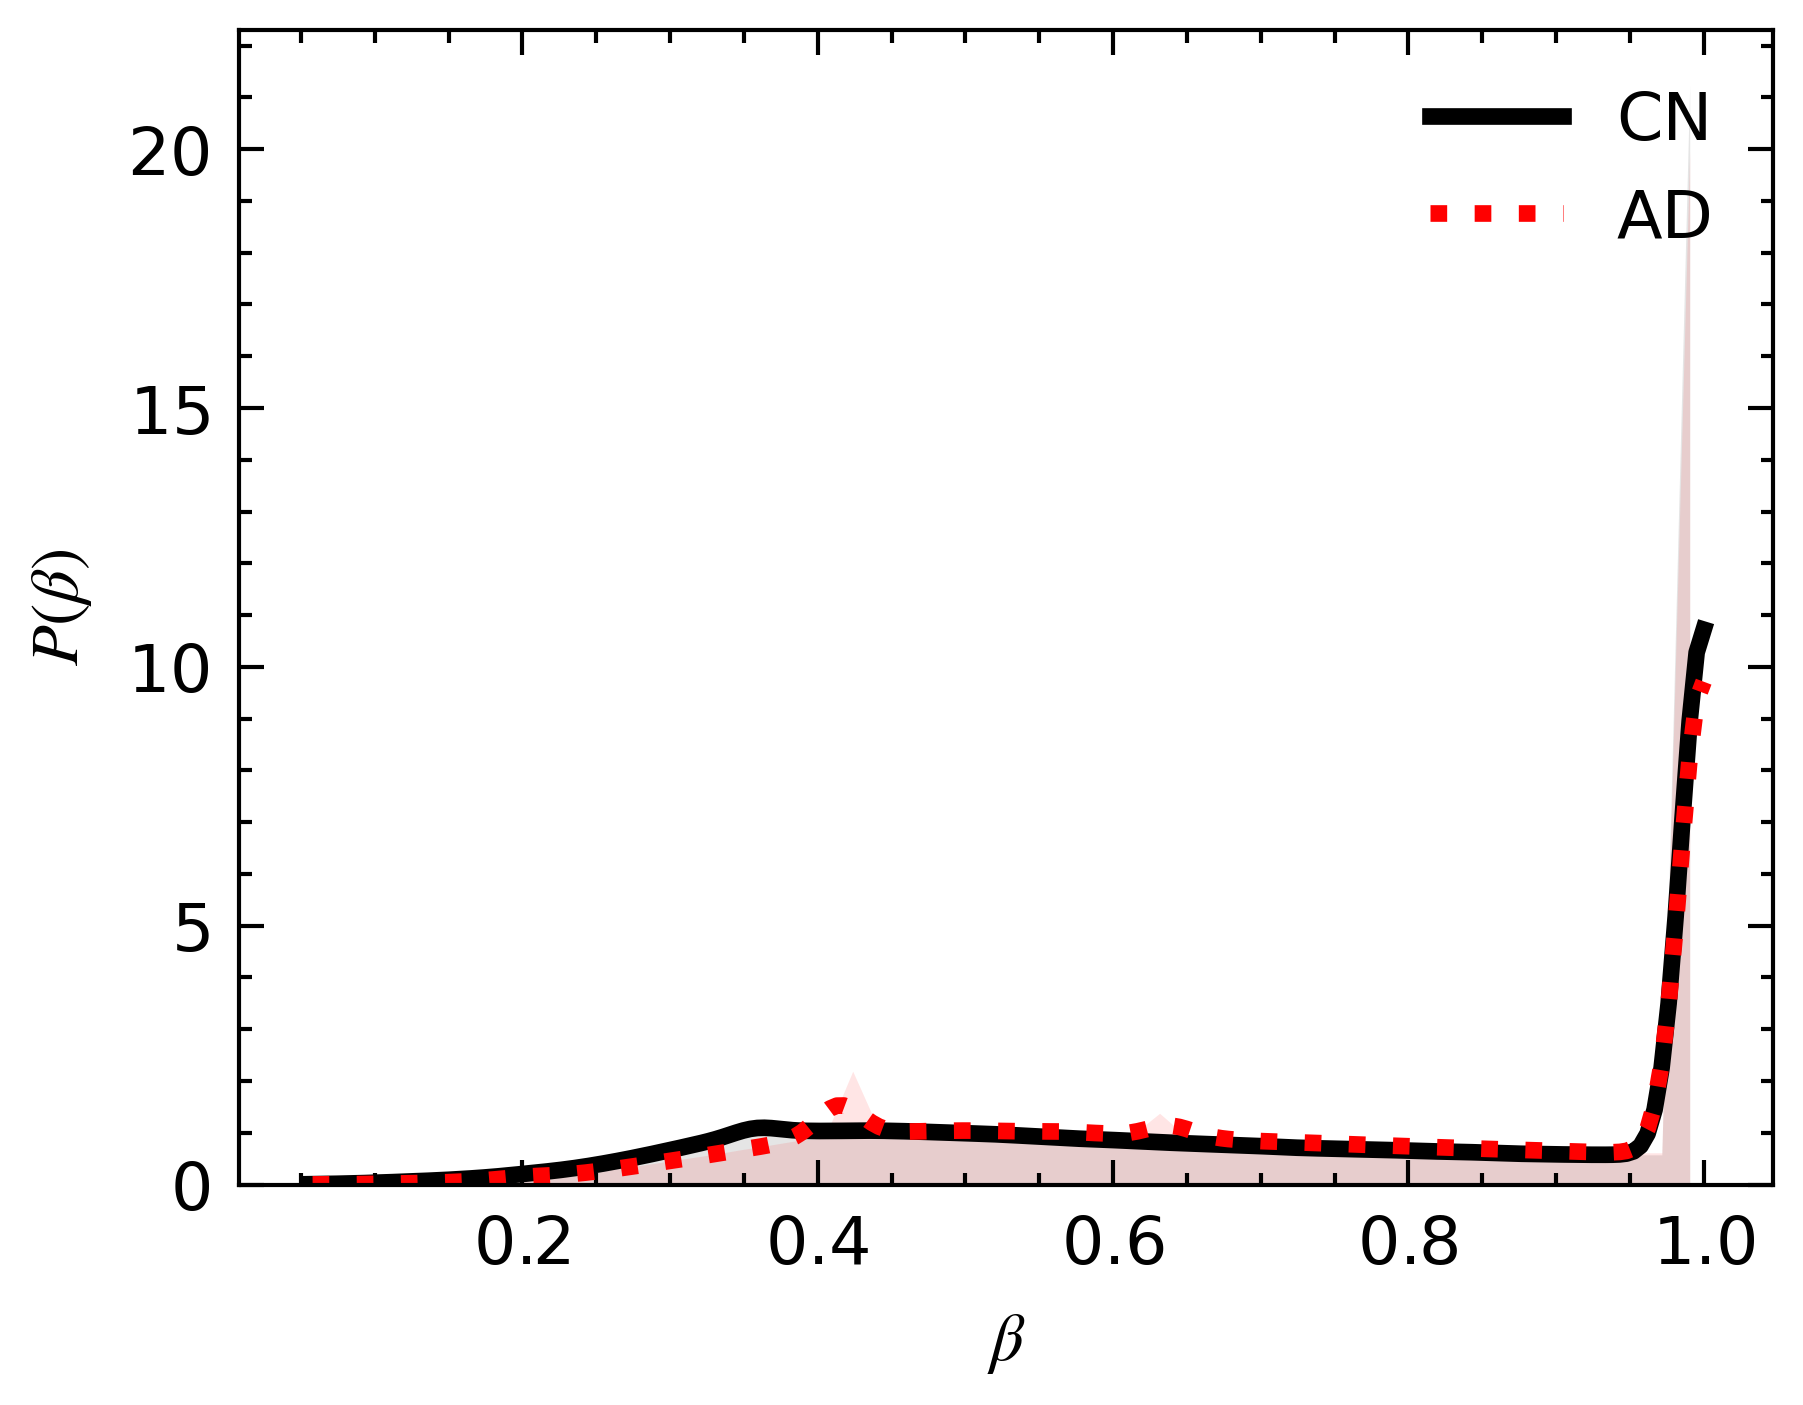

In [64]:
# bins_ad = optimal_bin_size(ad_betas[~np.isnan(ad_betas)])
# bins_cn = optimal_bin_size(cn_betas[~np.isnan(cn_betas)])
# print(bins_ad, bins_cn)
# bins = min(bins_ad, bins_cn)
# plt.hist(cn_betas[~np.isnan(cn_betas)], bins=60, label='CN', alpha=0.5, density=True)
# plt.hist(ad_betas[~np.isnan(ad_betas)], bins=60, label='AD', alpha=0.3, density=True)
betas = np.concatenate([ad_betas[~np.isnan(ad_betas)], cn_betas[~np.isnan(cn_betas)]])
bins = np.histogram_bin_edges(betas, bins=50)



sns.histplot(
    cn_betas[~np.isnan(cn_betas)], color='black', alpha=0.1,
    kde=True, stat='density', bins=bins, element='poly', linewidth=0,
    line_kws={'linestyle': '-', 'linewidth': 2, 'label' : 'CN'}
)
sns.histplot(
    ad_betas[~np.isnan(ad_betas)], color='red', alpha=0.1,
    kde=True, stat='density', bins=bins, element='poly', linewidth=0,
    line_kws={'linestyle': ':', 'linewidth': 2, 'label' : 'AD'}
)

# font = { 
#         'weight' : 'bold',
#         'size'   : 10
#     }
# matplotlib.rc('font', **font)

# sns.histplot(cn_betas[~np.isnan(cn_betas)], color='black',label='CN', kde=True, stat='density', bins=bins)
# plt.xlim(0, 1)
plt.xlabel('$\\beta$')
plt.ylabel('$P(\\beta)$')
# plt.title('Beta distribution')
plt.legend()
# plt.savefig('results/plots/beta_dist.svg', dpi=1200)
plt.savefig('results/plots/beta_dist.pdf', dpi=1200)
reset_rc_params()
plt.show()

In [34]:
cn_betas_mean.shape

(31569,)

In [48]:
reset_rc_params()

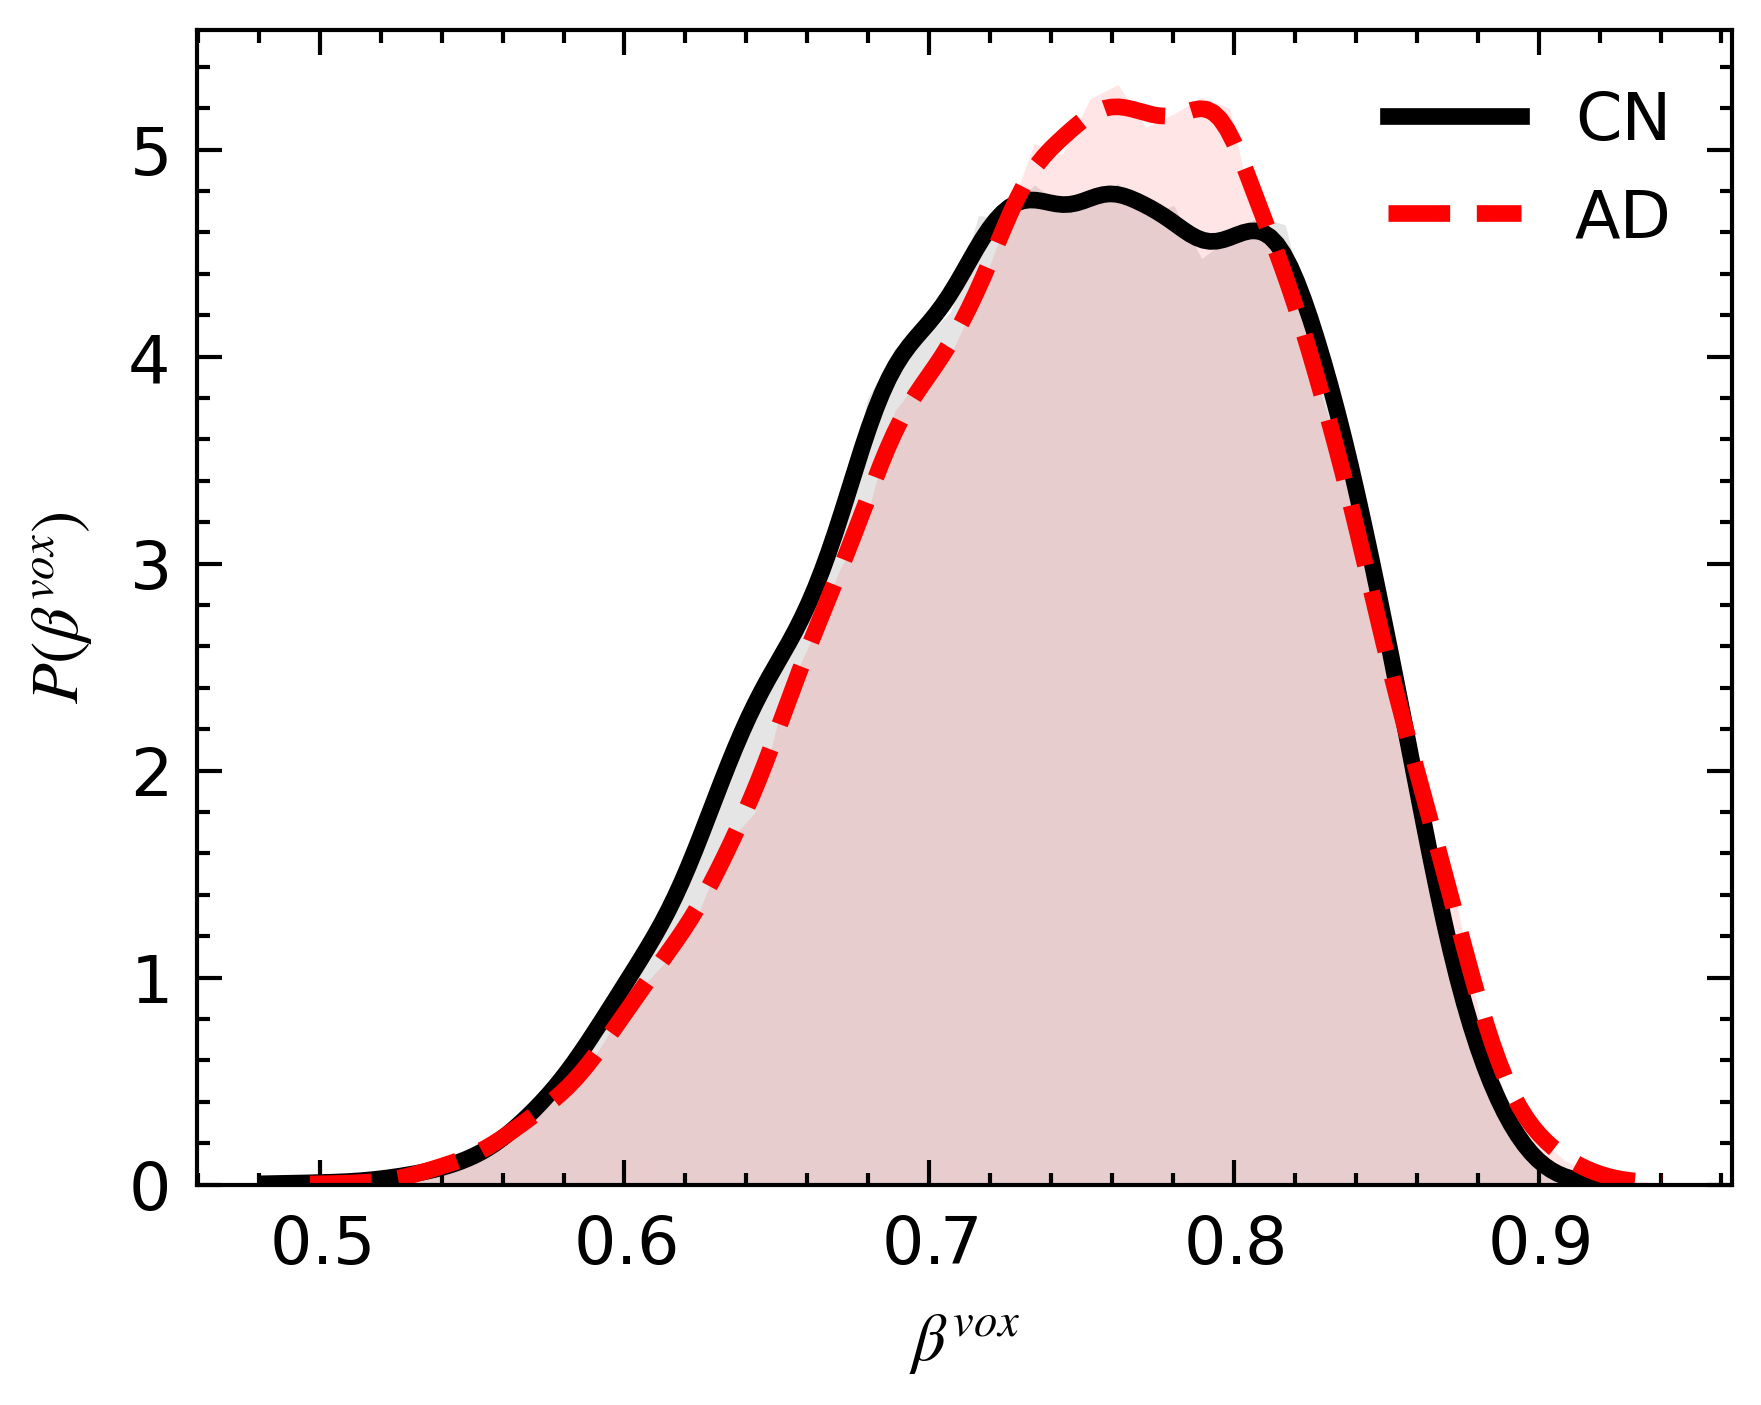

In [65]:
# bins_ad = optimal_bin_size(ad_betas_mean[~np.isnan(ad_betas_mean)])
# bins_cn = optimal_bin_size(cn_betas_mean[~np.isnan(cn_betas_mean)])
# print(bins_ad, bins_cn)
# bins = min(bins_ad, bins_cn)
# plt.hist(cn_betas_mean[~np.isnan(cn_betas_mean)], bins=60, label='CN', alpha=0.5, density=True)
# plt.hist(ad_betas_mean[~np.isnan(ad_betas_mean)], bins=60, label='AD', alpha=0.3, density=True)
betas = np.concatenate([ad_betas_mean[~np.isnan(ad_betas_mean)], cn_betas_mean[~np.isnan(cn_betas_mean)]])
bins = np.histogram_bin_edges(betas, bins=50)

# plt.figure(figsize=(8, 6))
# plt.rcParams.update({
#     'font.size': 20
# })
# font = { 
#         'weight' : 'bold',
#         'size'   : 20
#     }
# matplotlib.rc('font', **font)



sns.histplot(
    cn_betas_mean[~np.isnan(cn_betas_mean)], color='black', alpha=0.1,
    kde=True, stat='density', bins=bins, element='poly', linewidth=0,
    line_kws={'linestyle': '-', 'linewidth': 2, 'label' : 'CN'}
)
sns.histplot(
    ad_betas_mean[~np.isnan(ad_betas_mean)], color='red', alpha=0.1,
    kde=True, stat='density', bins=bins, element='poly', linewidth=0,
    line_kws={'linestyle': '--', 'linewidth': 2, 'label' : 'AD'}
)


# sns.histplot(cn_betas_mean[~np.isnan(cn_betas_mean)], color='black',label='CN', kde=True, stat='density', bins=bins)
# plt.xlim(0, 1)
plt.xlabel('$\\beta^{vox}$')
plt.ylabel('$P(\\beta^{vox})$')
# plt.title('Beta distribution')
# plt.legend()
# plt.savefig('results/plots/beta_dist_mean.svg', format='svg', dpi=1200, bbox_inches = "tight")
plt.legend()
plt.savefig('results/plots/beta_dist_mean.pdf', format='pdf', dpi=1200, bbox_inches = "tight")
# plt.savefig('results/plots/beta_dist_mean.png', format='png', dpi=1200, bbox_inches = "tight")
plt.show()
reset_rc_params()


In [46]:
k = rts_betas[:, sk]
np.sum(k < .95)/k.size

0.5894785134470917

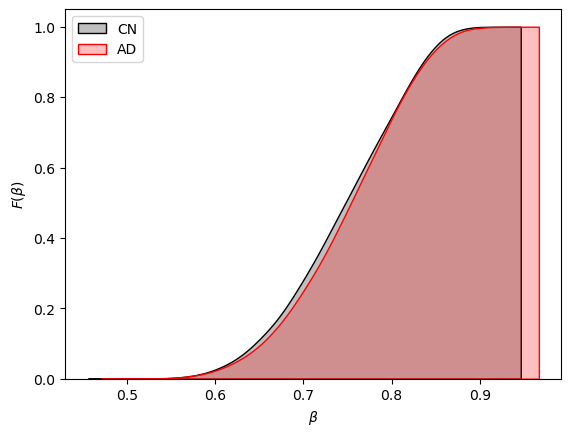

In [66]:
sns.kdeplot(data = cn_betas_mean[~np.isnan(cn_betas_mean)], cumulative = True, label = "CN", fill=True, color='black')
sns.kdeplot(data = ad_betas_mean[~np.isnan(ad_betas_mean)], cumulative = True, label = "AD", fill=True, color='red')
plt.legend(loc='upper left')
plt.xlabel('$\\beta$')
plt.ylabel('$F(\\beta)$')
plt.show()
# plt.savefig('results/plots/beta_cdf_dist.pdf', dpi=2400)

In [37]:
np.mean(all_ad_taus), np.mean(all_cn_taus)

(8.784359, 11.021568)

In [38]:
reset_rc_params()

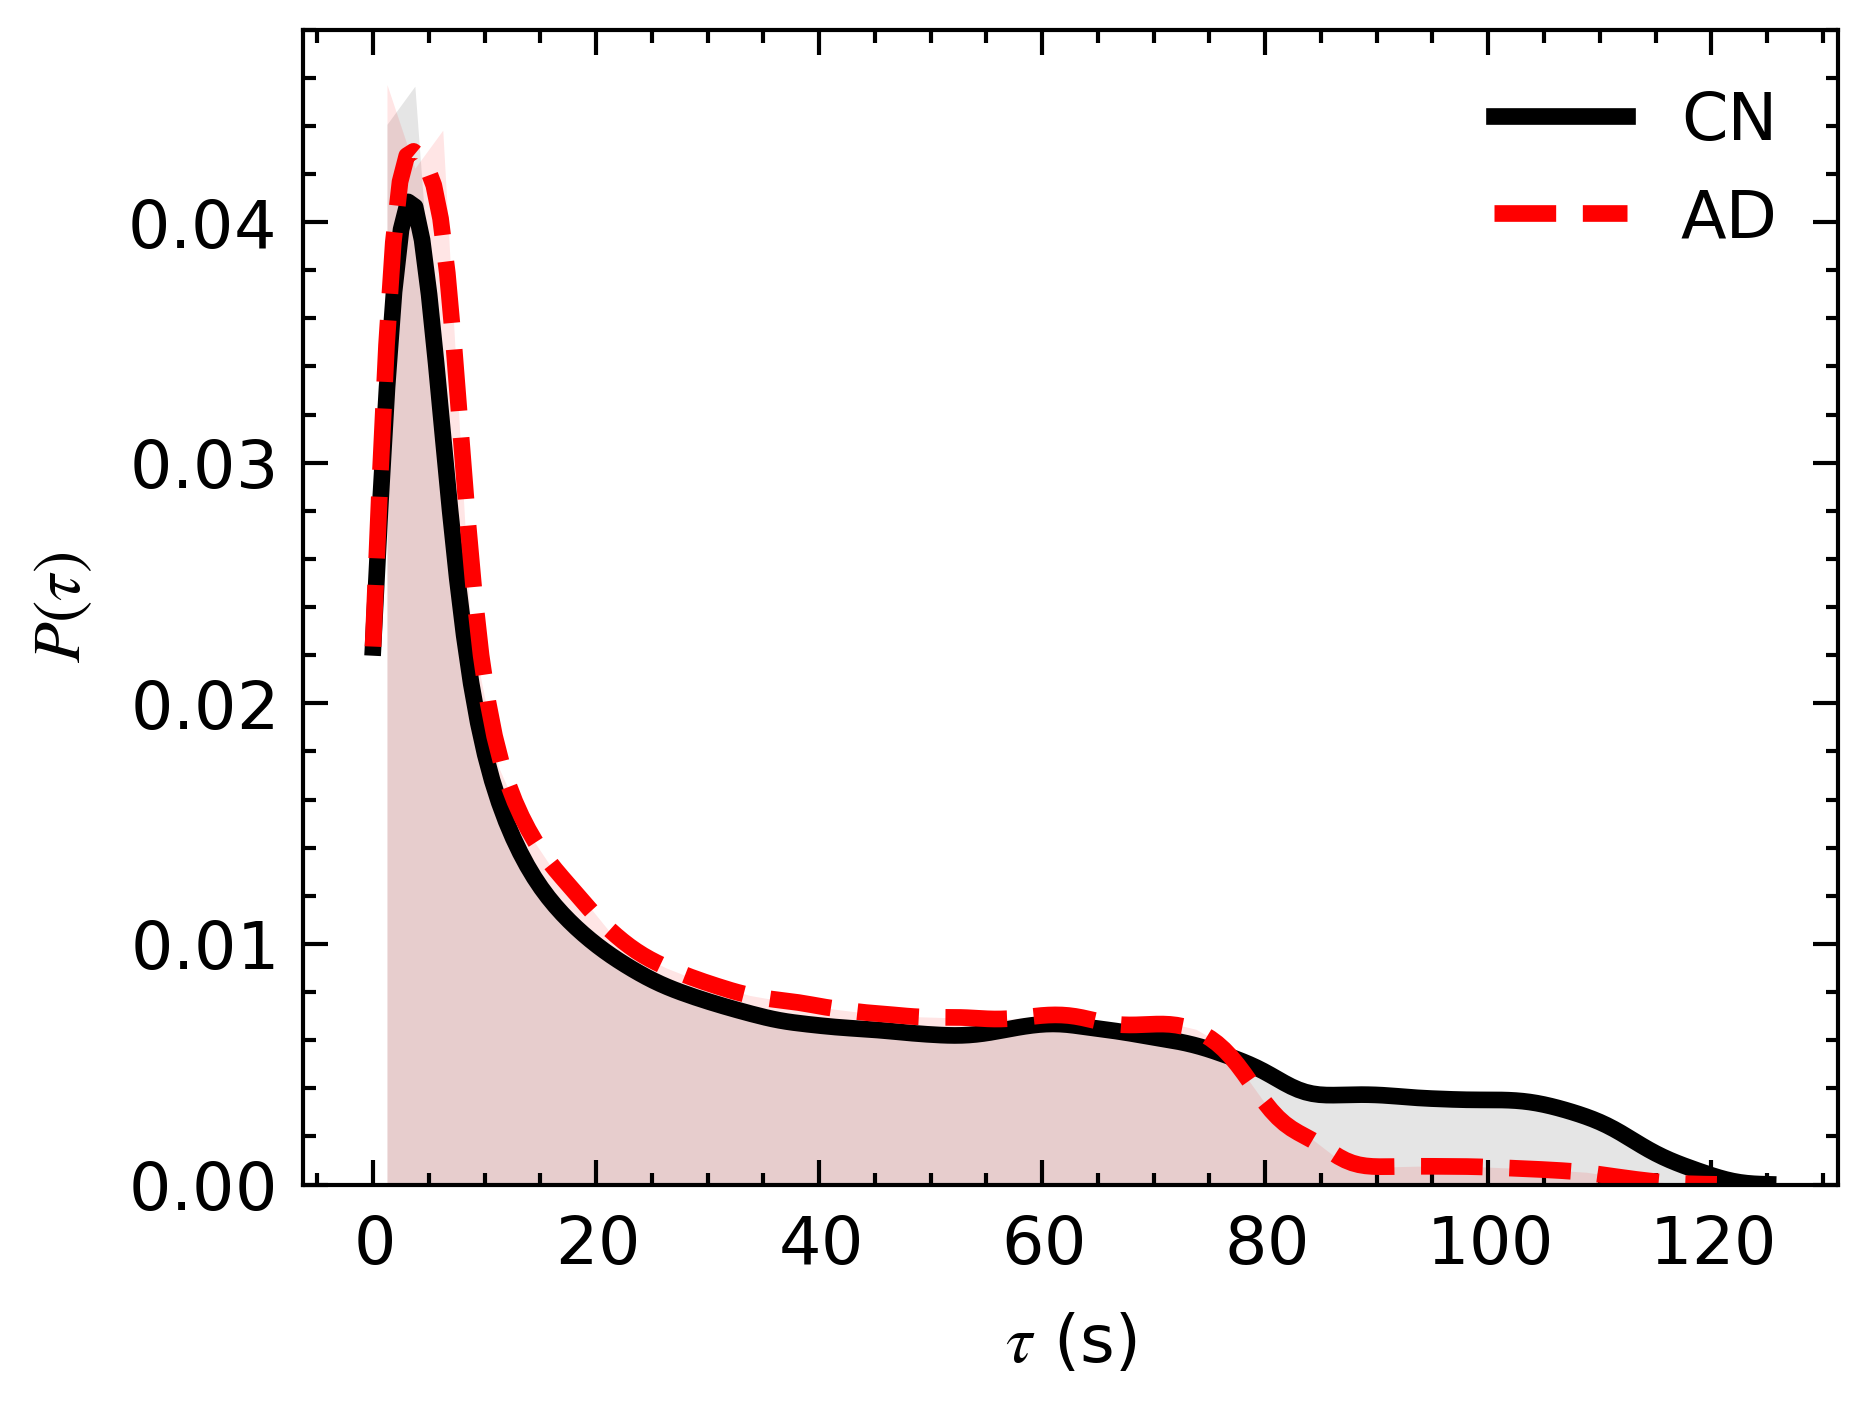

In [68]:
ad_plot = ad_taus[~np.isnan(ad_taus)] * 3
cn_plot = cn_taus[~np.isnan(cn_taus)] * 3

taus = np.concatenate([
    ad_plot, cn_plot 
    ]) 
bins = np.histogram_bin_edges(taus, bins=50)

sns.histplot(
    cn_plot, color='black', alpha=0.1,
    kde=True, stat='density', bins=bins, element='poly', linewidth=0,
    line_kws={'linestyle': '-', 'linewidth': 2, 'label' : 'CN'}
)
sns.histplot(
    ad_plot, color='red', alpha=0.1,
    kde=True, stat='density', bins=bins, element='poly', linewidth=0,
    line_kws={'linestyle': '--', 'linewidth': 2, 'label' : 'AD'}
)

# sns.histplot(ad_taus_mean[~np.isnan(ad_taus_mean)]*3, fill=True, color='red', label='AD', \
#              kde=True, bins=bins, stat='density', kde_kws = {'bw_adjust': 1})
# sns.histplot(cn_taus_mean[~np.isnan(cn_taus_mean)]*3, fill=True,color='black',label='CN', \
#              kde=True, bins=bins, stat='density', kde_kws = {'bw_adjust': 1})
# sns.kdeplot(all_ad_taus[~np.isnan(all_ad_taus)], fill=True, color='red', label='AD')
# sns.kdeplot(all_cn_taus[~np.isnan(all_cn_taus)], fill=True,color='black',label='CN')
# plt.hist(all_cn_taus[~np.isnan(all_cn_taus)], bins=60, label='CN', alpha=0.5, density=True)
# plt.hist(all_ad_taus[~np.isnan(all_ad_taus)], bins=60, label='AD', alpha=0.3, density=True)
plt.xlabel('$\\tau$ (s)')
plt.ylabel('$P(\\tau)$')
plt.legend()
# plt.savefig('results/plots/taus_dist.svg', dpi=1200)
plt.savefig('results/plots/taus_dist.pdf', dpi=1200)
plt.show()


In [46]:
reset_rc_params()

In [78]:
pvals = stats.ttest_ind(ad_taus, cn_taus).pvalue

In [81]:
np.reshape(cn_taus_nonans, (len(cn_taus_nonans), 1)).shape

(1736178, 1)

In [80]:
stats.ttest_ind(np.reshape(cn_taus_nonans, (len(cn_taus_nonans), 1)), np.reshape(ad_taus_nonans, (len(ad_taus_nonans), 1)))

Ttest_indResult(statistic=array([184.79186355]), pvalue=array([0.]))

In [70]:
cn_taus_nonans.shape, ad_taus_nonans.shape

((1736178,), (1073341,))

In [69]:
stats.ttest_ind(cn_taus_nonans.flatten(), ad_taus_nonans.flatten())

Ttest_indResult(statistic=184.7918640284445, pvalue=0.0)

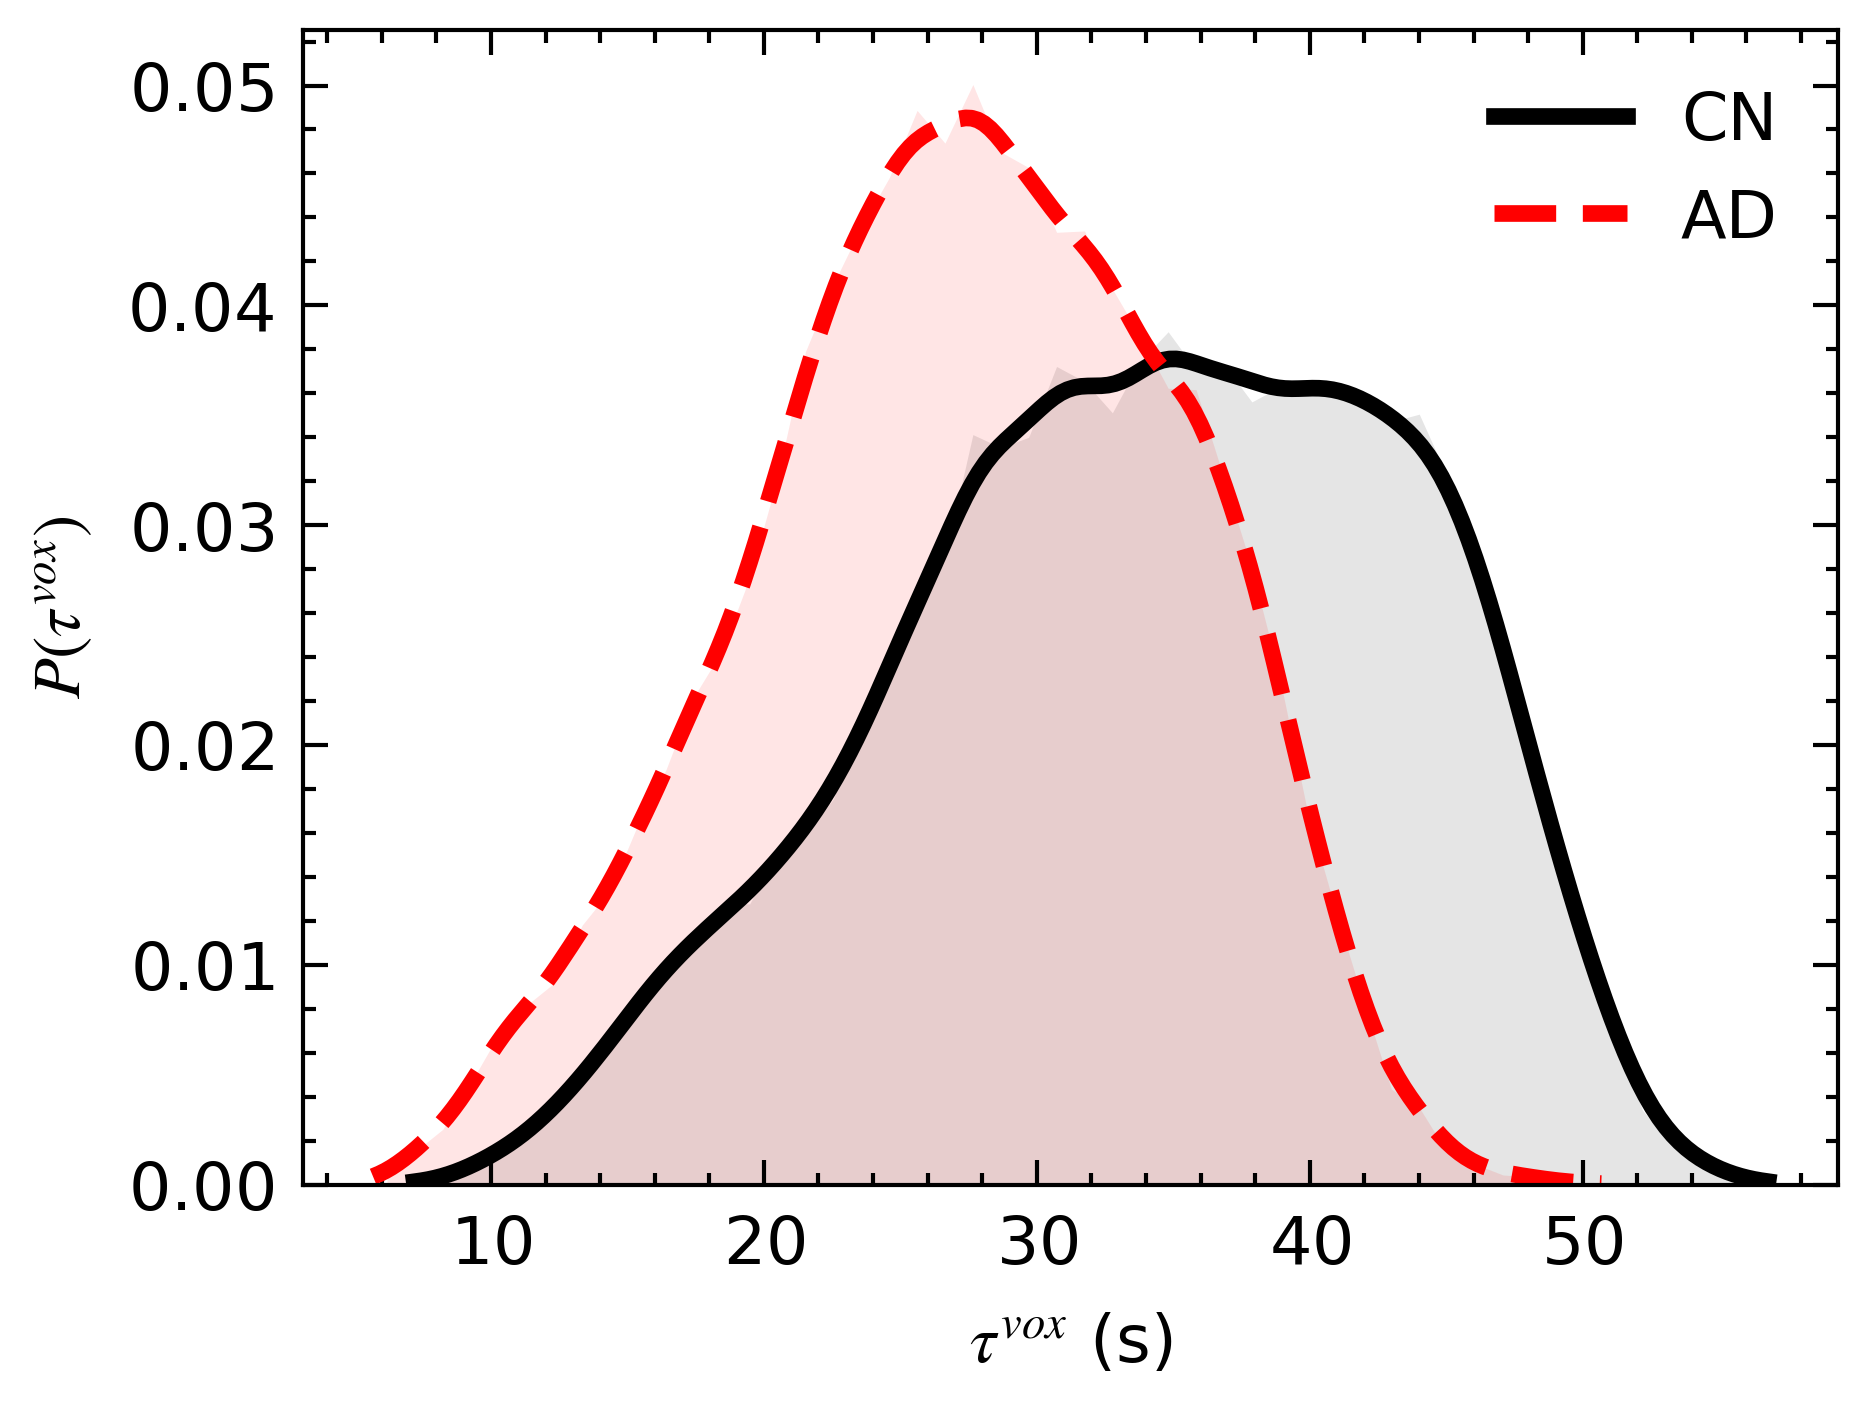

In [67]:
ad_plot = ad_taus_mean[~np.isnan(ad_taus_mean)] * 3
cn_plot = cn_taus_mean[~np.isnan(cn_taus_mean)] * 3

taus = np.concatenate([
    ad_plot, cn_plot 
    ]) 
bins = np.histogram_bin_edges(taus, bins=50)

# plt.figure(figsize=(8, 6))
# plt.rcParams.update({
#     'font.size': 20
# })

sns.histplot(
    cn_plot, color='black', alpha=0.1,
    kde=True, stat='density', bins=bins, element='poly', linewidth=0,
    line_kws={'linestyle': '-', 'linewidth': 2, 'label' : 'CN'}
)
sns.histplot(
    ad_plot, color='red', alpha=0.1,
    kde=True, stat='density', bins=bins, element='poly', linewidth=0,
    line_kws={'linestyle': '--', 'linewidth': 2, 'label' : 'AD'}
)

# sns.histplot(ad_taus_mean[~np.isnan(ad_taus_mean)]*3, fill=True, color='red', label='AD', \
#              kde=True, bins=bins, stat='density', kde_kws = {'bw_adjust': 1})
# sns.histplot(cn_taus_mean[~np.isnan(cn_taus_mean)]*3, fill=True,color='black',label='CN', \
#              kde=True, bins=bins, stat='density', kde_kws = {'bw_adjust': 1})
# sns.kdeplot(all_ad_taus[~np.isnan(all_ad_taus)], fill=True, color='red', label='AD')
# sns.kdeplot(all_cn_taus[~np.isnan(all_cn_taus)], fill=True,color='black',label='CN')
# plt.hist(all_cn_taus[~np.isnan(all_cn_taus)], bins=60, label='CN', alpha=0.5, density=True)
# plt.hist(all_ad_taus[~np.isnan(all_ad_taus)], bins=60, label='AD', alpha=0.3, density=True)
plt.xlabel('$\\tau^{vox}$ (s)')
plt.ylabel('$P(\\tau^{vox})$')
plt.legend()
reset_rc_params()
# plt.savefig('results/plots/taus_dist_mean.svg', dpi=1200, bbox_inches = "tight")
plt.savefig('results/plots/taus_dist_mean.pdf', dpi=1200, bbox_inches = "tight")
plt.show()

### Means and other stats

In [62]:
print("taus*3:\tAD\tCN")
print("Means:\t", np.round(np.nanmean(ad_taus*3), 3), np.round(np.nanmean(cn_taus*3), 3))
print("STDs:\t", np.round(np.nanstd(ad_taus*3), 3), np.round(np.nanstd(cn_taus*3), 3))
print("Medians:", np.round(np.nanmedian(ad_taus*3), 3), np.round(np.nanmedian(cn_taus*3), 3))

taus*3:	AD	CN
Means:	 27.485 34.315
STDs:	 25.928 32.415
Medians: 17.489 22.648


In [63]:
print("taus_mean*3:\tAD\tCN")
print("Means:\t", np.round(np.nanmean(ad_taus_mean*3), 3), np.round(np.nanmean(cn_taus_mean*3), 3))
print("STDs:\t", np.round(np.nanstd(ad_taus_mean*3), 3), np.round(np.nanstd(cn_taus_mean*3), 3))
print("Medians:", np.round(np.nanmedian(ad_taus_mean*3), 3), np.round(np.nanmedian(cn_taus_mean*3), 3))

taus_mean*3:	AD	CN
Means:	 27.485 34.315
STDs:	 7.656 9.193
Medians: 27.664 34.797


In [59]:
print("betas:\tAD\tCN")
print("Means:\t", np.round(np.nanmean(ad_betas), 3), np.round(np.nanmean(cn_betas), 3))
print("STDs:\t", np.round(np.nanstd(ad_betas), 3), np.round(np.nanstd(cn_betas), 3))
print("Medians:", np.round(np.nanmedian(ad_betas), 3), np.round(np.nanmedian(cn_betas), 3))

betas:	AD	CN
Means:	 0.749 0.744
STDs:	 0.249 0.264
Medians: 0.796 0.815


In [61]:
print("betas_mean:\tAD\tCN")
print("Means:\t", np.round(np.nanmean(ad_betas_mean), 3), np.round(np.nanmean(cn_betas_mean), 3))
print("STDs:\t", np.round(np.nanstd(ad_betas_mean), 3), np.round(np.nanstd(cn_betas_mean), 3))
print("Medians:", np.round(np.nanmedian(ad_betas_mean), 3), np.round(np.nanmedian(cn_betas_mean), 3))

betas_mean:	AD	CN
Means:	 0.749 0.744
STDs:	 0.07 0.071
Medians: 0.754 0.748


# Stretched Exponential Visualisation

In [63]:
class RelaxationTime:
    def __init__(self, root_dir, SCRATCH_DATA_DIR):
        self.dloader = DataLoader(root_dir)
     
    @staticmethod
    def autocorr(x):
        xp = x - np.mean(x)
        n = len(x)
        f = np.fft.fft(xp, n*2)
        acf = np.real(np.fft.ifft(f * np.conjugate(f))[:n])
        # acf /= (4*np.var(x))
        acf /= acf[0]
        return acf
    
    @staticmethod
    def st_exp_decay(t, tau, beta, A, B=0):
        return A * np.exp(-np.power(t/tau, beta)) + B

    @staticmethod
    def exp_decay(t, tau, A, B=0):
        return A * np.exp(-t/tau) + B
   
    @staticmethod
    def get_st_exp_fit(x, t_max=None):
        t = list(range(len(x)))
        if t_max is None:
            t_max = len(t) // 2
        p0 = [t[t_max], 1]
        bounds = [[0, 0], [np.inf, 1.0]]
        B = np.mean(x[t_max//2: t_max])
        A = 1 - B
        func = lambda t, tau, beta: RelaxationTime.st_exp_decay(t, tau, beta=beta, A=A, B=B)
        popt, pcov = curve_fit(func, t[:t_max], x[:t_max], p0=p0, bounds=bounds)
        se = np.sqrt(np.mean(np.diag(pcov)))
        t = np.array(t)
    #     print(t.shape)
        res = x - func(t, *popt)
        rmse = np.sqrt(np.mean(res**2))
        tau = popt[0]
        beta = popt[1]
        return tau, beta, A, B, rmse, se
    @staticmethod
    def get_exp_fit(x, t_max=None):
        t = list(range(len(x)))                                            
        if t_max is None:
            t_max = len(t) // 2
        p0 = [t[t_max]]
        bounds = [[0], [np.inf]]
        B = np.mean(x[50:])
        A = 1 - B
        func = lambda t, tau: RelaxationTime.exp_decay(t, tau, A=A, B=B)
        popt, pcov = curve_fit(func, t[:t_max], x[:t_max], p0=p0, bounds=bounds)
        se = np.sqrt(np.mean(np.diag(pcov)))
        t = np.array(t)
    #     print(t.shape)
        res = x - func(t, *popt)
        rmse = np.sqrt(np.mean(res**2))
        tau = popt[0]
        return tau, A, B, rmse, se
    
    def w_fit(self, sub_idx, fl_idx):
        func_data = self.dloader.get_func(sub_idx, get_image=False)
        vox_idx = np.unravel_index(fl_idx, shape=func_data.shape[:-1])
        data = func_data[vox_idx]
        t = np.arange(len(data))
        signal = self.autocorr(data)
        st_fit = self.get_st_exp_fit(signal)
        exp_fit = self.get_exp_fit(signal)
        return t, signal, st_fit, exp_fit
        
    def plot_w_fit(self, sub_idx, fl_idx):
        func_data = self.dloader.get_func(sub_idx, get_image=False)
        vox_idx = np.unravel_index(fl_idx, shape=func_data.shape[:-1])
        data = func_data[vox_idx]
        t = np.arange(len(data))
        signal = self.autocorr(data)
        plt.plot(t*3, signal, label='$\\rho(t)$')
        st_fit = self.get_st_exp_fit(signal)
        beta_str = f'{st_fit[1]:.2f}'
        tau_stexp_str = f'{st_fit[0]*3:.2f}'
        label='$\\tau_{st-exp}='+tau_stexp_str+'$, '+'$\\beta='+beta_str+'$'
        plt.plot(t*3, self.st_exp_decay(t, *st_fit[:-2]), label=label)
        try: 
            exp_fit = self.get_exp_fit(signal)
            tau_exp_str = f'{exp_fit[0]*3:.2f}'
            label = '$\\tau_{exp}='+tau_exp_str+'$'
            plt.plot(t*3, self.exp_decay(t, *exp_fit[:-2]), label=label)
#             plt.ylabel('$ACF(s)$')
            plt.xlabel('$t$ (s)')
        except:
            print('Exp fit failed')
        plt.legend()
        return plt
    
    def plot_w_fit_log(self, sub_idx, fl_idx):
        func_data = self.dloader.get_func(sub_idx, get_image=False)
        vox_idx = np.unravel_index(fl_idx, shape=func_data.shape[:-1])
        data = func_data[vox_idx]
        t = np.arange(len(data))
        signal = self.autocorr(data)
        plt.plot(np.log(signal[signal>0]))
        st_fit = self.get_st_exp_fit(signal)
        exp_fit = self.get_exp_fit(signal)
        plt.plot(np.log(self.st_exp_decay(t, *st_fit[:-2])), label=f'St exp tau={st_fit[0]:.2f}, beta={st_fit[1]:.2f}, rmse={st_fit[4]:.2f}')
        plt.plot(np.log(self.exp_decay(t, *exp_fit[:-2])), label=f'Exp tau={exp_fit[0]:.2f}, rmse={exp_fit[3]:.2f}')
        plt.legend()
        return plt
rt = RelaxationTime(root_dir, SCRATCH_DATA_DIR)


In [64]:

# diff = abs(rts_taus_exp - rts_taus)
rts_taus_filt = np.array(rts_taus)
# rts_taus_filt[rts_taus_exp < 3] = rts_taus_exp[rts_taus_exp < 3]
rts_taus_filt.shape

(89, 228939)

In [65]:
criteria = (rts_taus > 5) & (rts_taus_exp-rts_taus<1)
idx  = np.where(criteria)
idx_n = np.where(rts_taus>5)
print(len(idx[0])/len(idx_n[0]))

0.6467044357321885


2220715
012_S_4026 190451


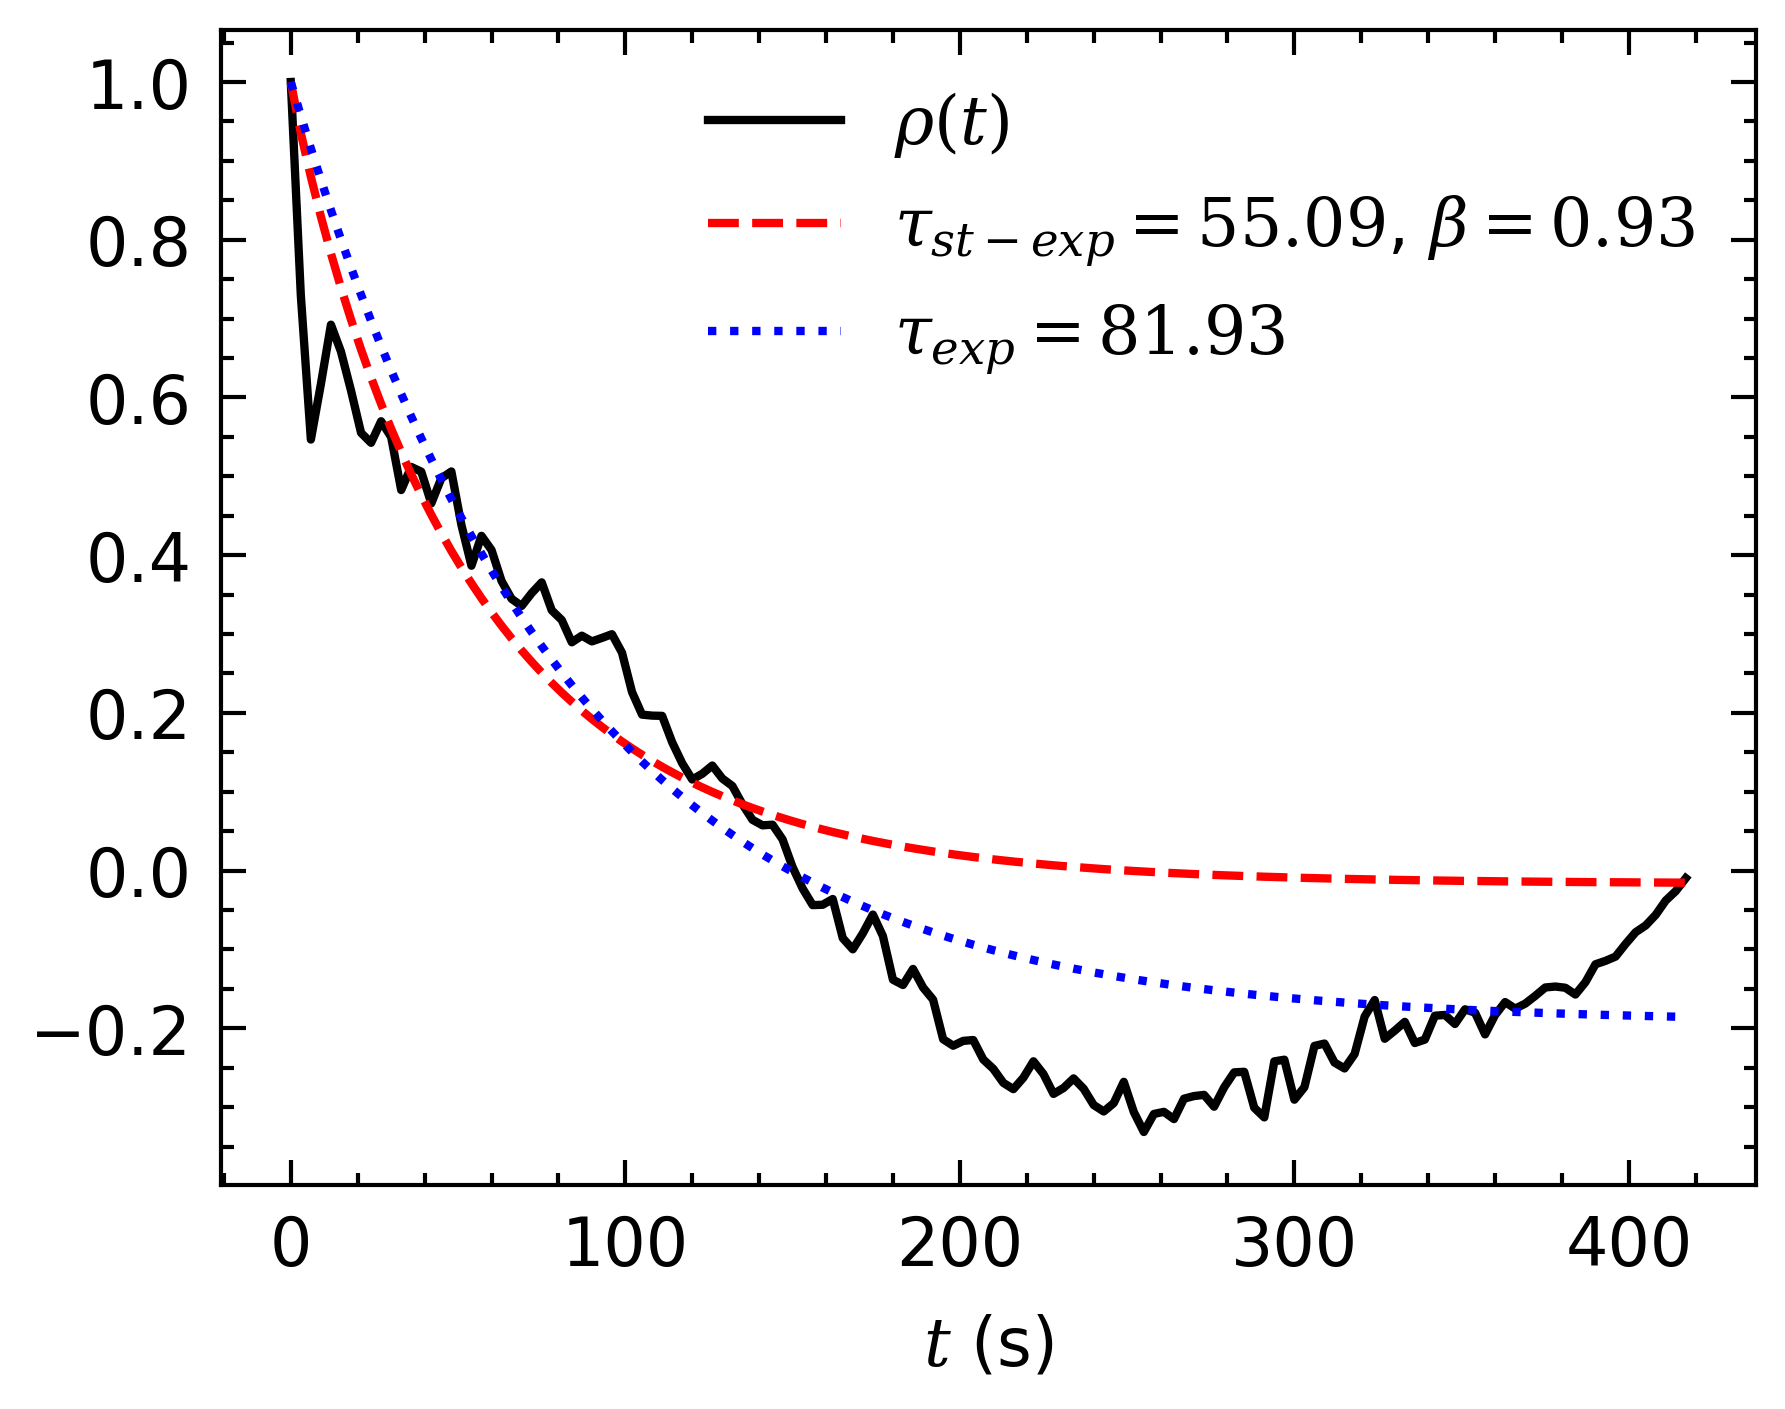

In [68]:
# idx = np.where((rts_taus_exp < 10)& (rts_taus_exp >8)) 
# criteria = (rts_taus_exp < 20) & (rts_taus_exp >15)
rts_taus_filt = rts_taus
# criteria = (rts_betas >.99) & (rts_betas <1.1) & (rts_taus > 20)
criteria = (rts_taus < 20) 
idx = np.where(criteria)
# idx = np.where((rts_taus_exp < 10) & (rts_betas >0.9) & (rts_betas <1.1)) 
# idx = np.where((diff < 0.5) & (diff > 0) & (rts_taus_exp > 6) & (rts_taus_exp < 7))
# print(idx)
print(len(idx[0]))
# for i in [1.3, 5, 10, 20]:
for i in [20]:
    if i < 3:
        criteria = (rts_taus_filt < i) & (rts_taus_filt >i-1)
    else: 
#         criteria = (rts_taus_filt < i) & (rts_taus_filt >i-1) & (rts_taus_exp-rts_taus>4)
        criteria = (rts_taus_filt < i) & (rts_taus_filt >i-2)
    idx = np.where(criteria)
    n = np.random.choice(len(idx[0]))
    sub_idx = dloader.subjects_list[rts_fl_idx[idx[0][n]]]
    fl_idx = idx[1][n]
    print(sub_idx, fl_idx)
    plt = rt.plot_w_fit(sub_idx, fl_idx)
    plt.savefig(f'results/plots/st_rep/{i}_{sub_idx}.svg')
    plt.show()
# for i in range(5):
#     n = np.random.choice(len(idx[0]))
#     sub_idx = dloader.subjects_list[rts_fl_idx[idx[0][n]]]
#     fl_idx = idx[1][n]
#     print(sub_idx, fl_idx)
#     plt = rt.plot_w_fit(sub_idx, fl_idx)
#     plt.savefig(f'results/plots/st_rep/{i}_{sub_idx}.pdf', dpi=2400)
#     plt.show()

100_S_4511 51700


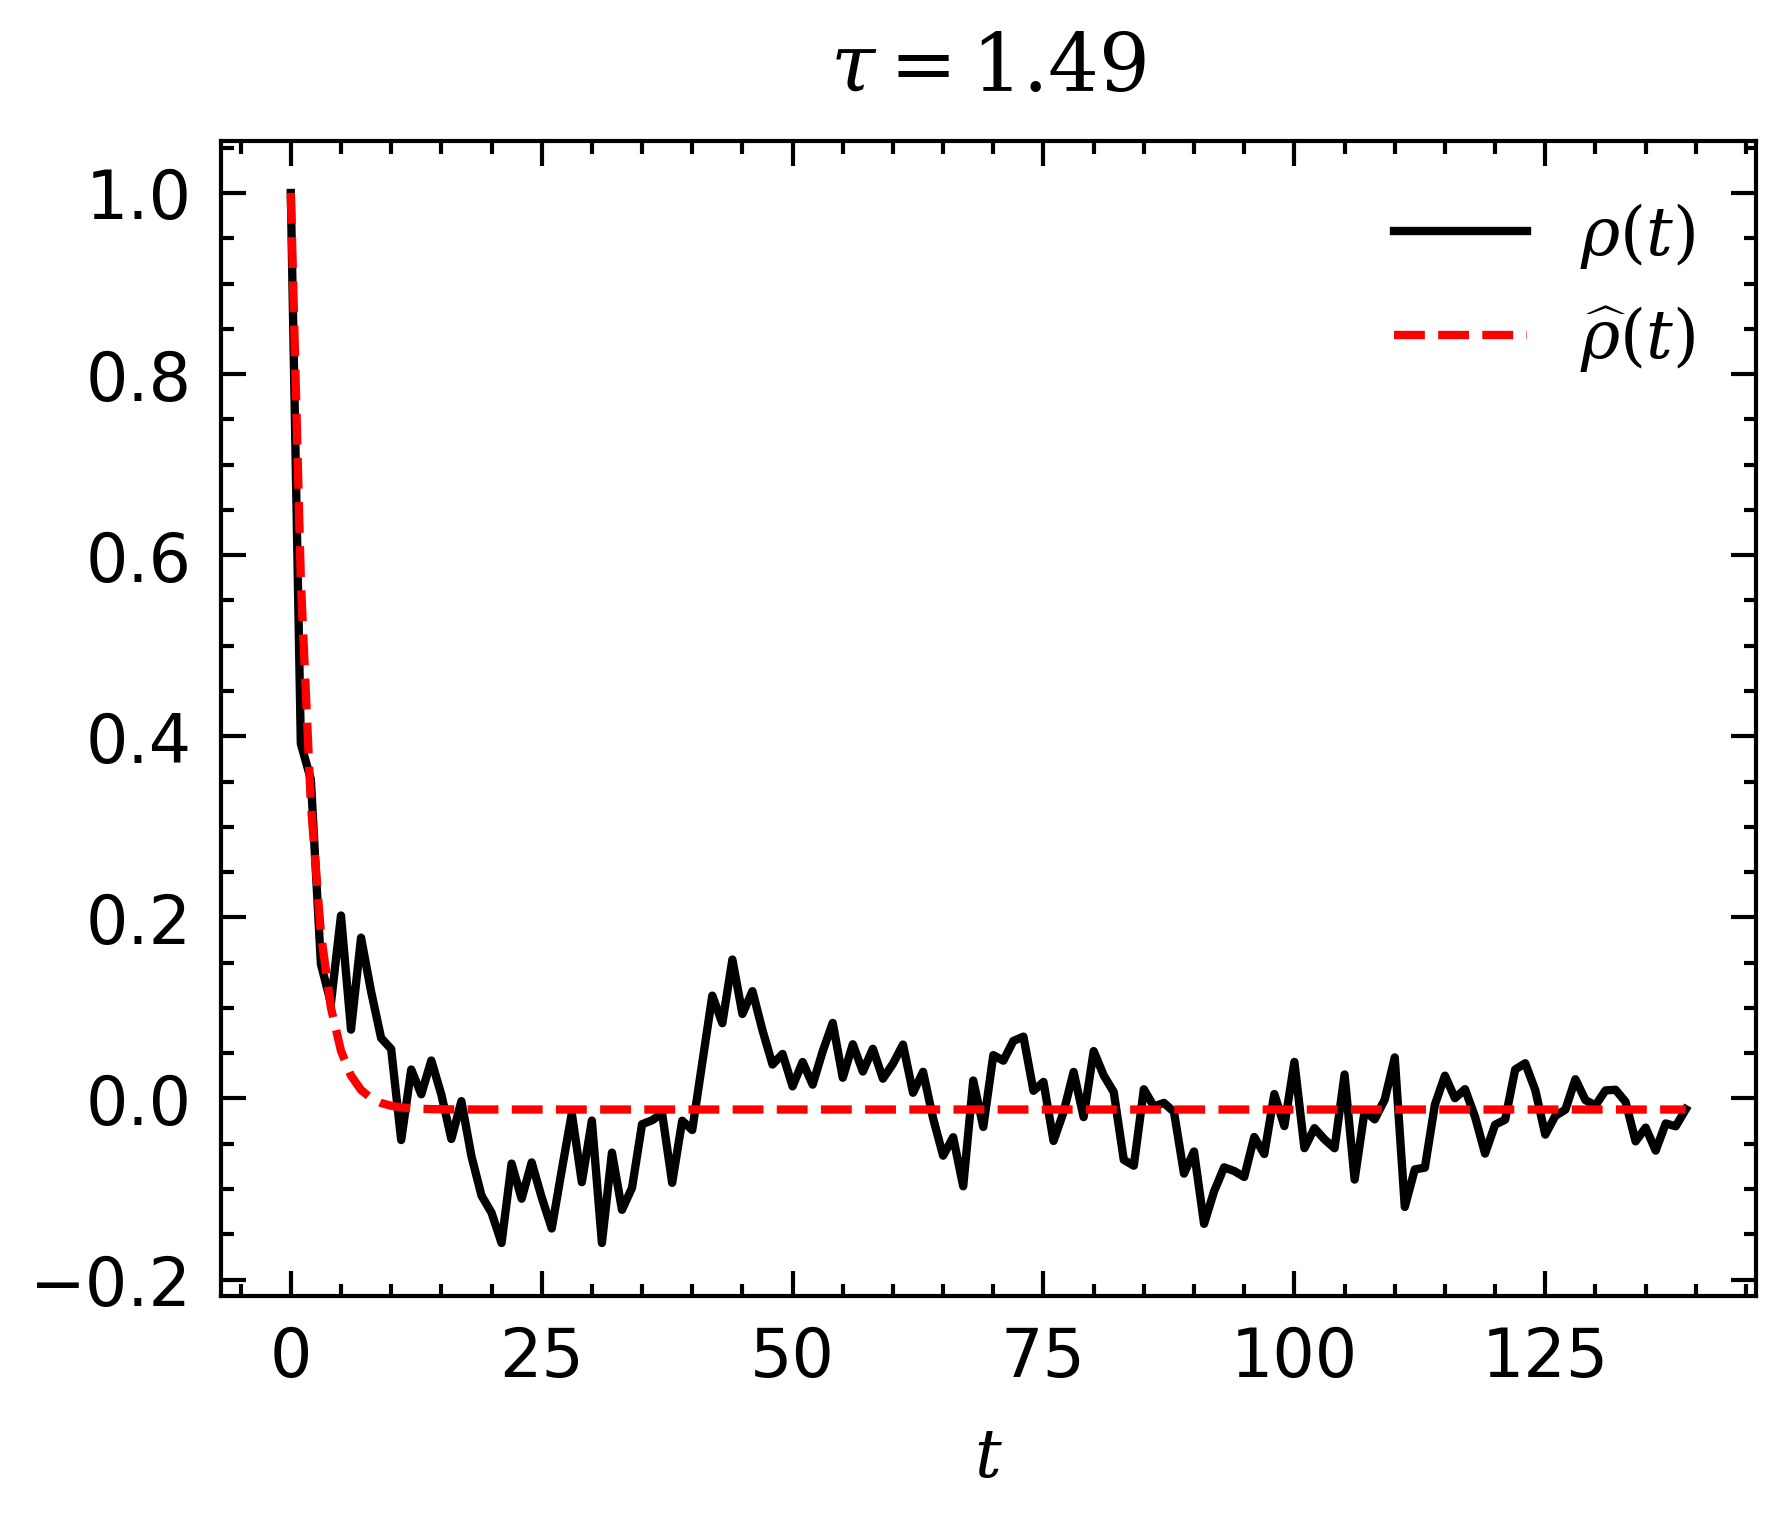

013_S_4731 131887


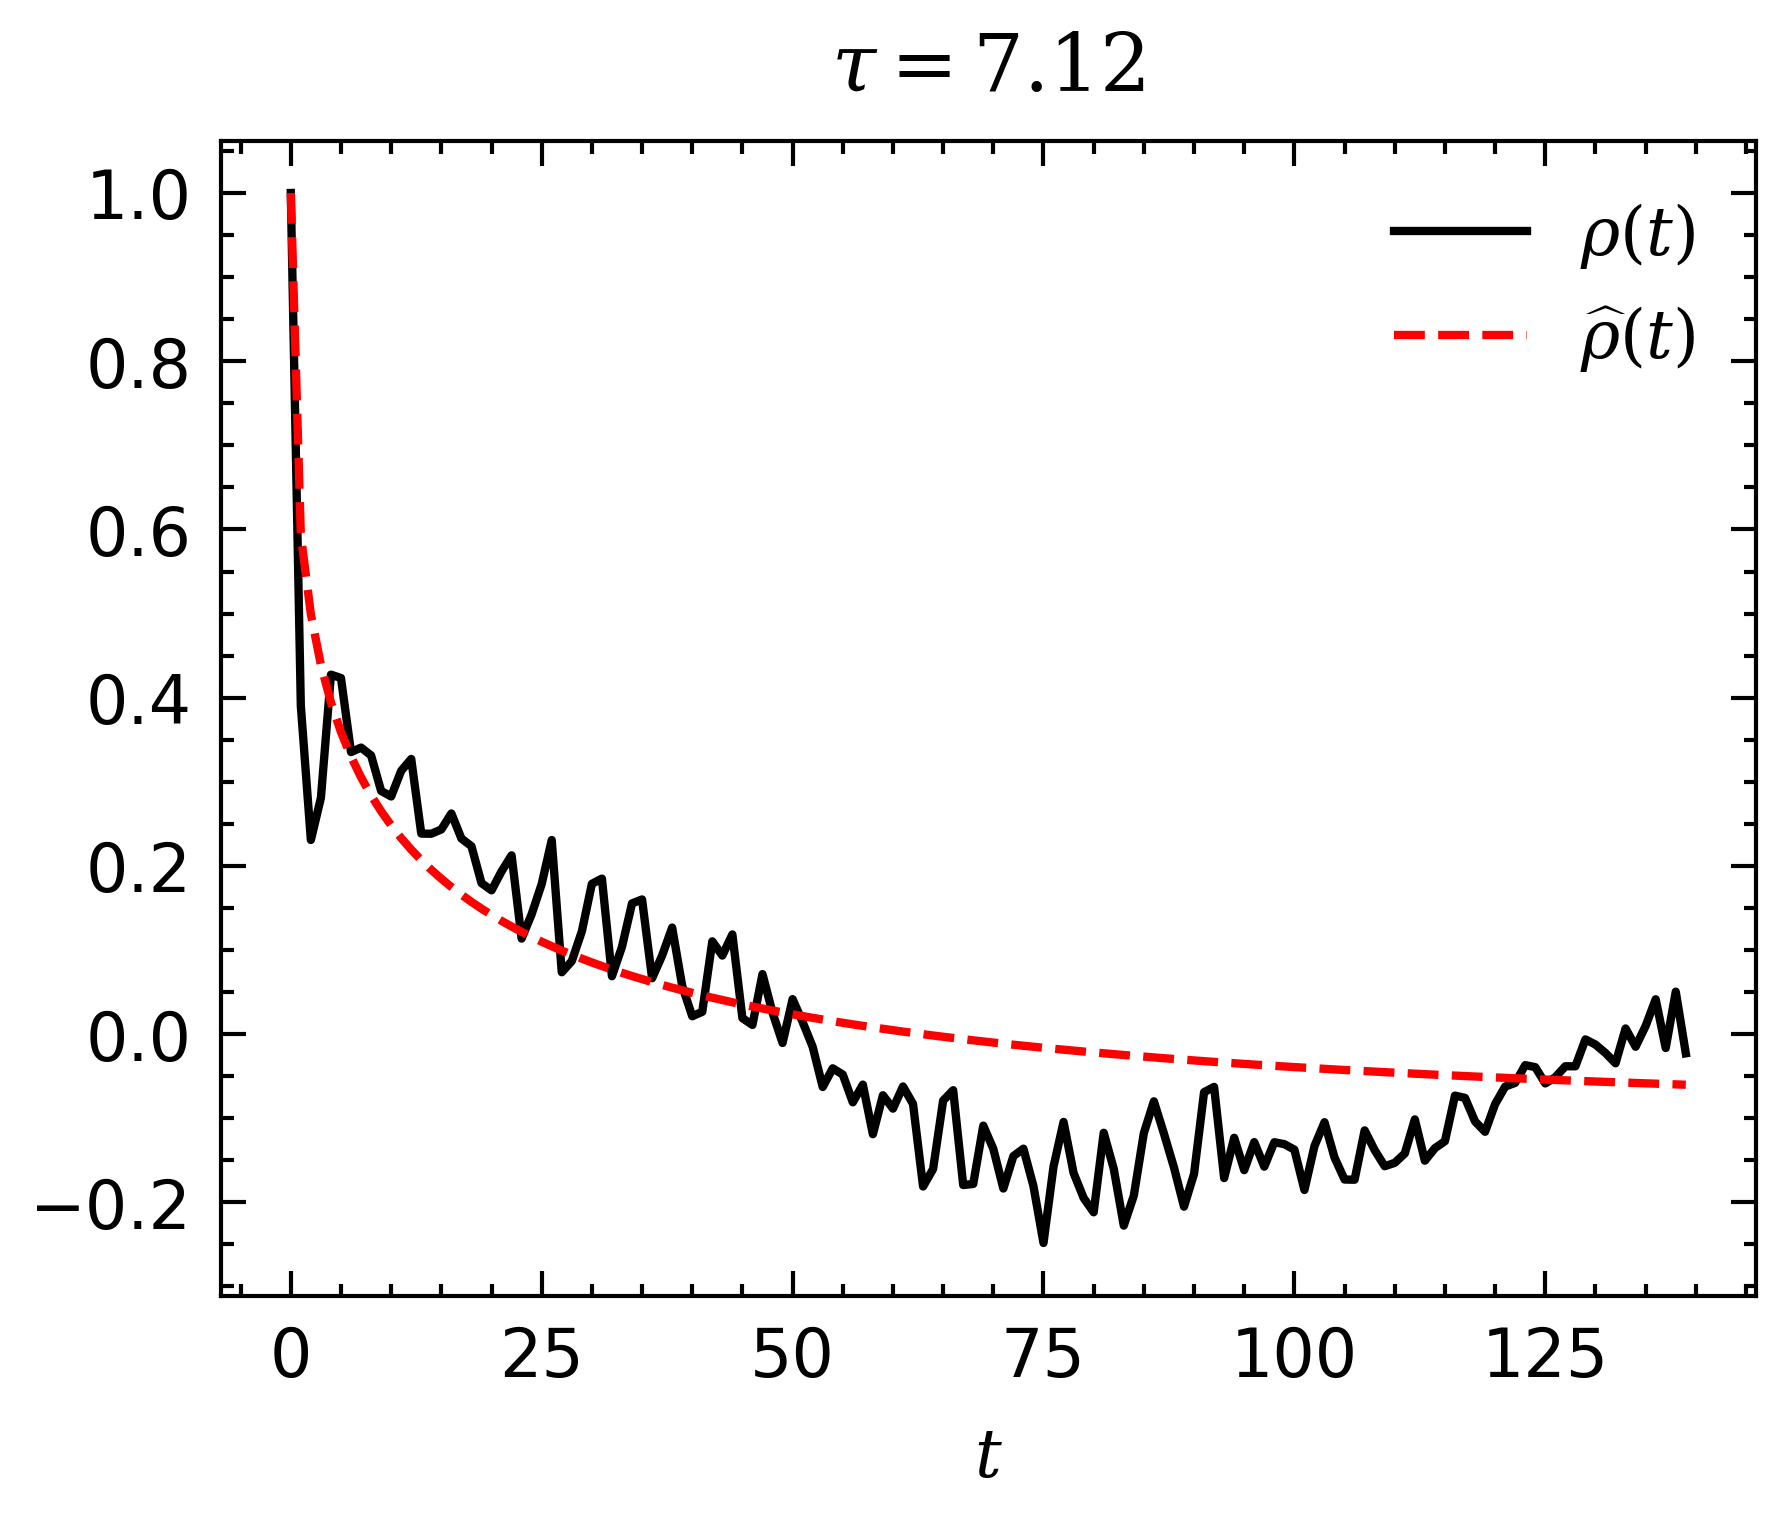

130_S_5231 176525


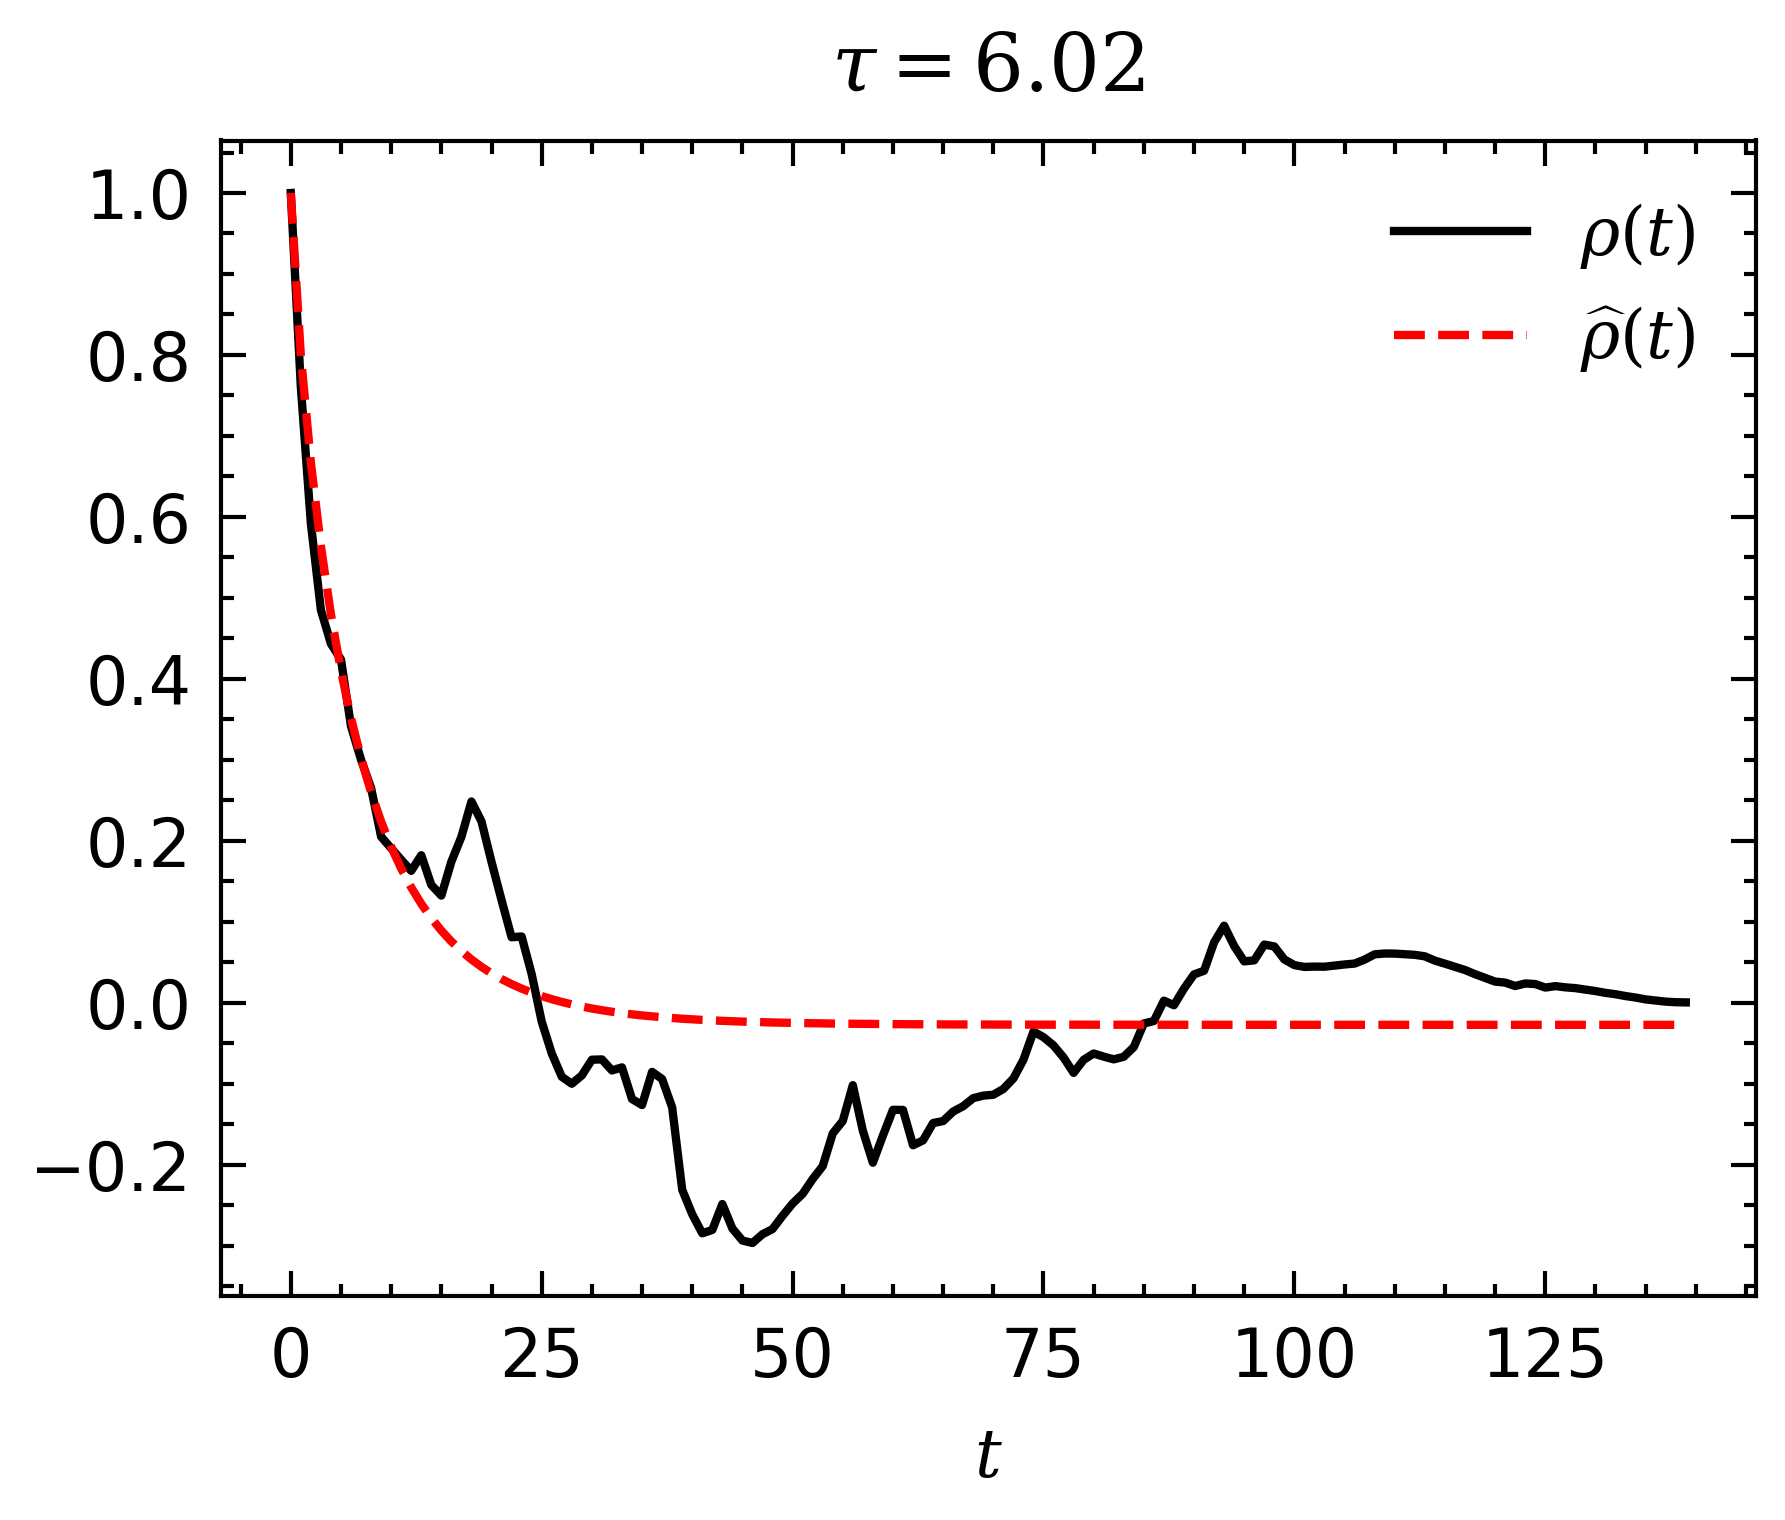

031_S_4218 47271


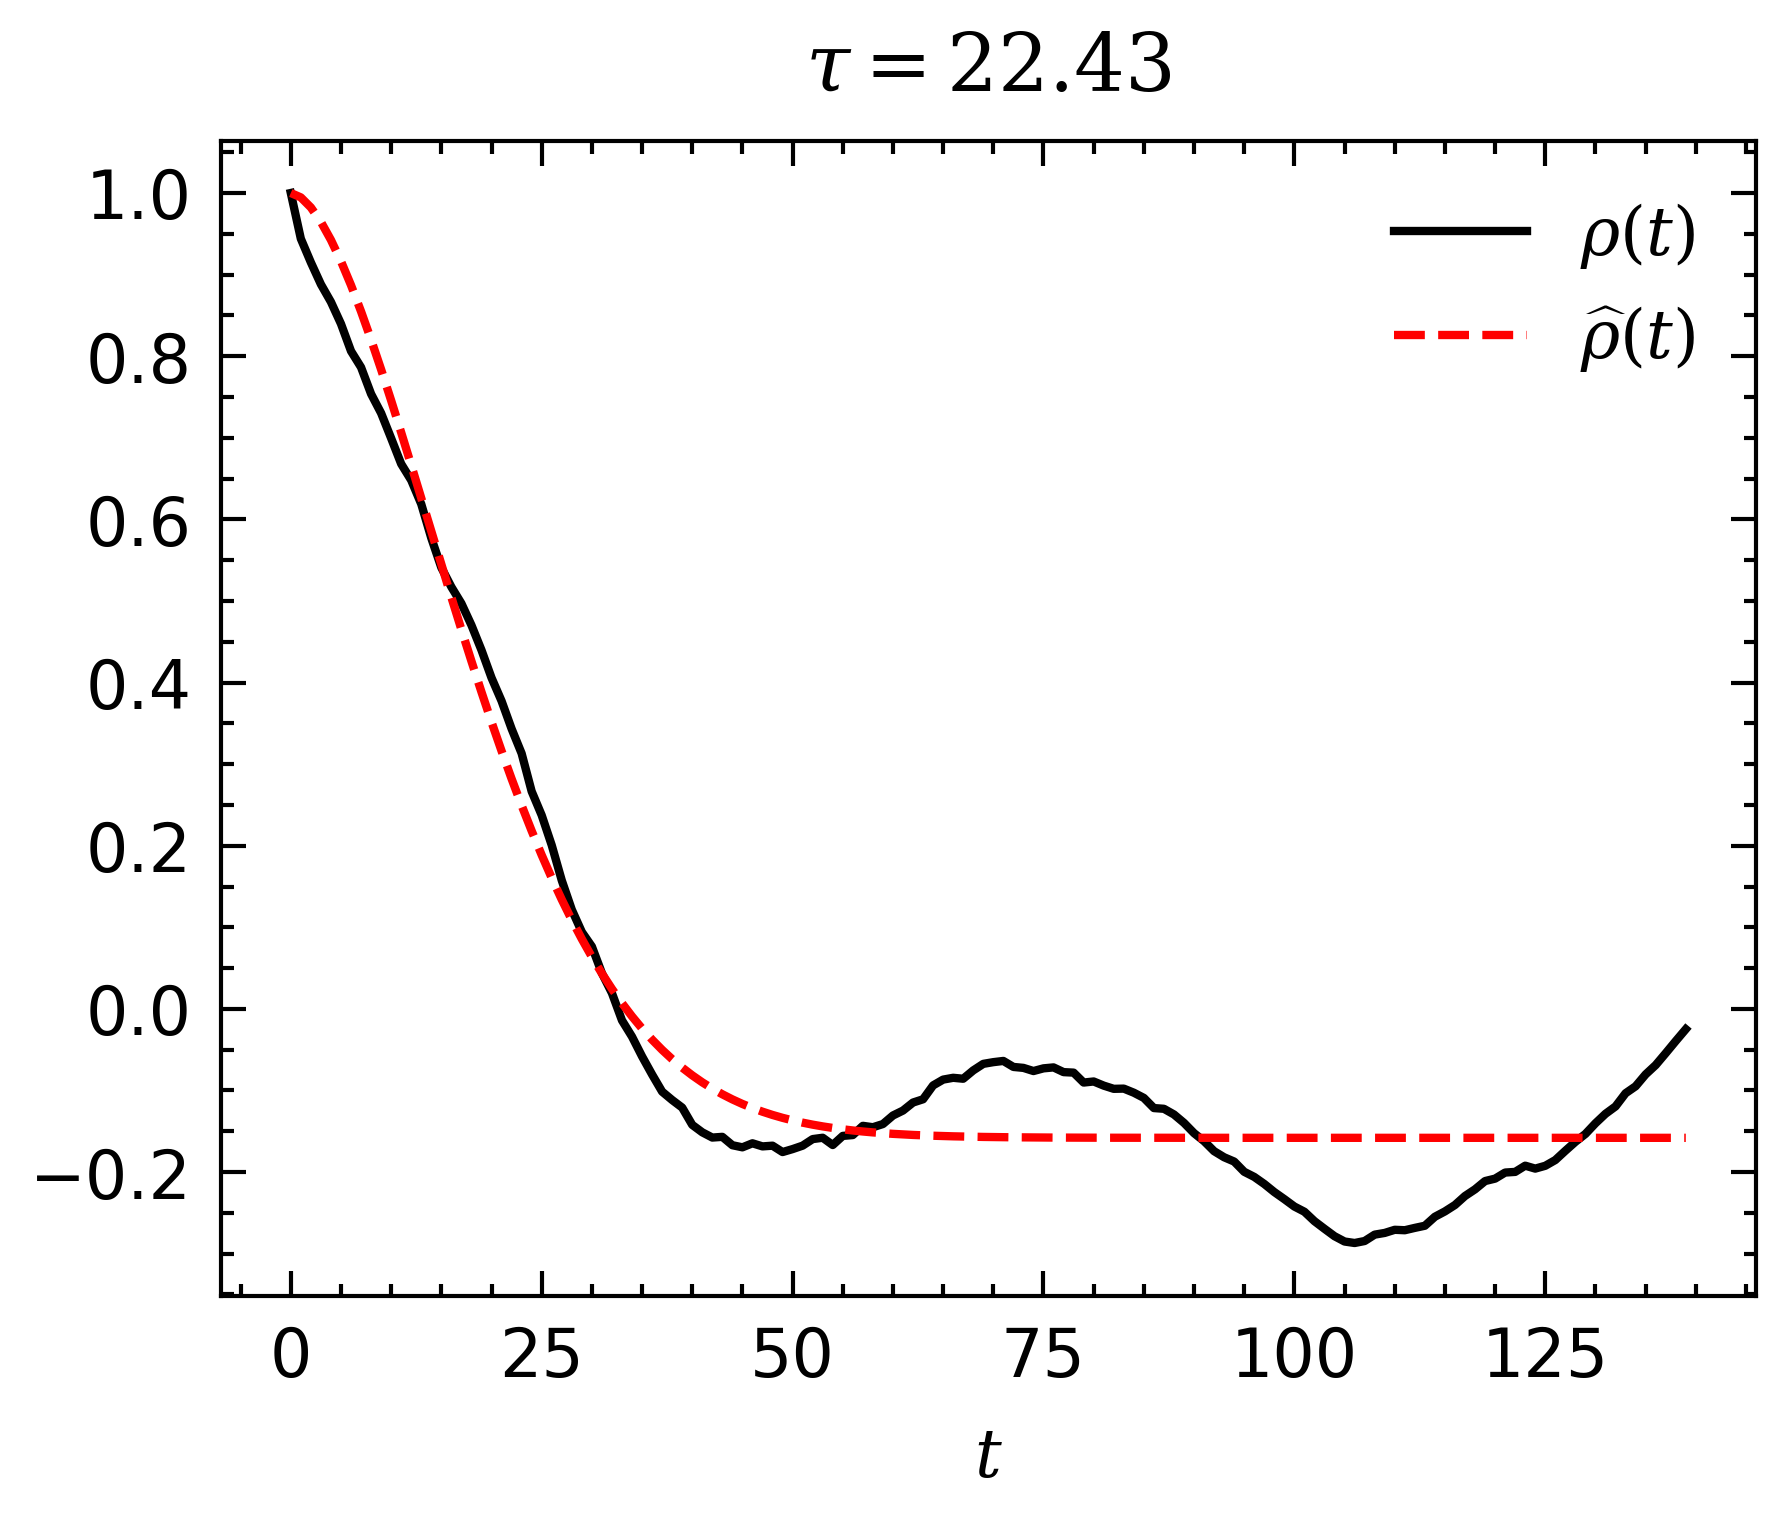

In [54]:
# criteria = (rts_taus_filt < 3)
# idx = np.where(criteria)
# idx = np.where((rts_taus_exp < 10) & (rts_betas >0.9) & (rts_betas <1.1)) 
# idx = np.where((diff < 0.5) & (diff > 0) & (rts_taus_exp > 6) & (rts_taus_exp < 7))
# print(idx)
# fig, ax = plt.subplots(2, 2)
# print(len(idx[0]))
rts_taus_filt = rts_taus
for idx, i in enumerate([2, 5, 10, 20]):
    ax_idx = divmod(idx, 2)
    criteria = (rts_taus_filt < i) & (rts_taus_filt >i-1)
    idx = np.where(criteria)
    n = np.random.choice(len(idx[0]))
    sub_idx = dloader.subjects_list[rts_fl_idx[idx[0][n]]]
    fl_idx = idx[1][n]
    print(sub_idx, fl_idx)
    t, signal, st_fit, exp_fit = rt.w_fit(sub_idx, fl_idx)
    label='$\\tau='+f'{st_fit[0]:.2f}'+'$'
#     ax[ax_idx].set_title(label)
#     ax[ax_idx].plot(signal, label='$\\rho(s)$')
    plt.title(label)
    plt.plot(signal, label='$\\rho(t)$')
    if st_fit[0] > 3:
#         ax[ax_idx].plot(rt.st_exp_decay(t, *st_fit[:-2]), label='$\widehat{\\rho(s)}$')
        plt.plot(rt.st_exp_decay(t, *st_fit[:-2]), label='$\widehat{\\rho}(t)$')
    else:
#         ax[ax_idx].plot(rt.exp_decay(t, *exp_fit[:-2]), label='$\widehat{\\rho(s)}$')
        plt.plot(rt.exp_decay(t, *exp_fit[:-2]), label='$\widehat{\\rho}(t)$')
    plt.xlabel('$t$')
    plt.legend()
    plt.savefig(f'results/plots/tau_rep/{st_fit[0]:.2f}.png')
    plt.show()


In [79]:
# np.save("/home/shivansh.seth/phase_diagram_analysis/results/rts_taus_filt.npy", rts_taus_filt)

## Plots

### $P(\tau)$ plots with zoomed-in image of low tau and high tau regions

In [36]:
ad_taus = np.array([ rts_taus_filt[i] for i in range(rts_taus.shape[0]) if dloader.diag[rts_fl_idx[i]] == 1 ])
cn_taus = np.array([ rts_taus_filt[i] for i in range(rts_taus.shape[0]) if dloader.diag[rts_fl_idx[i]] == 0 ])
ad_taus_mean, cn_taus_mean = np.nanmean(ad_taus, axis=0), np.nanmean(cn_taus, axis=0)

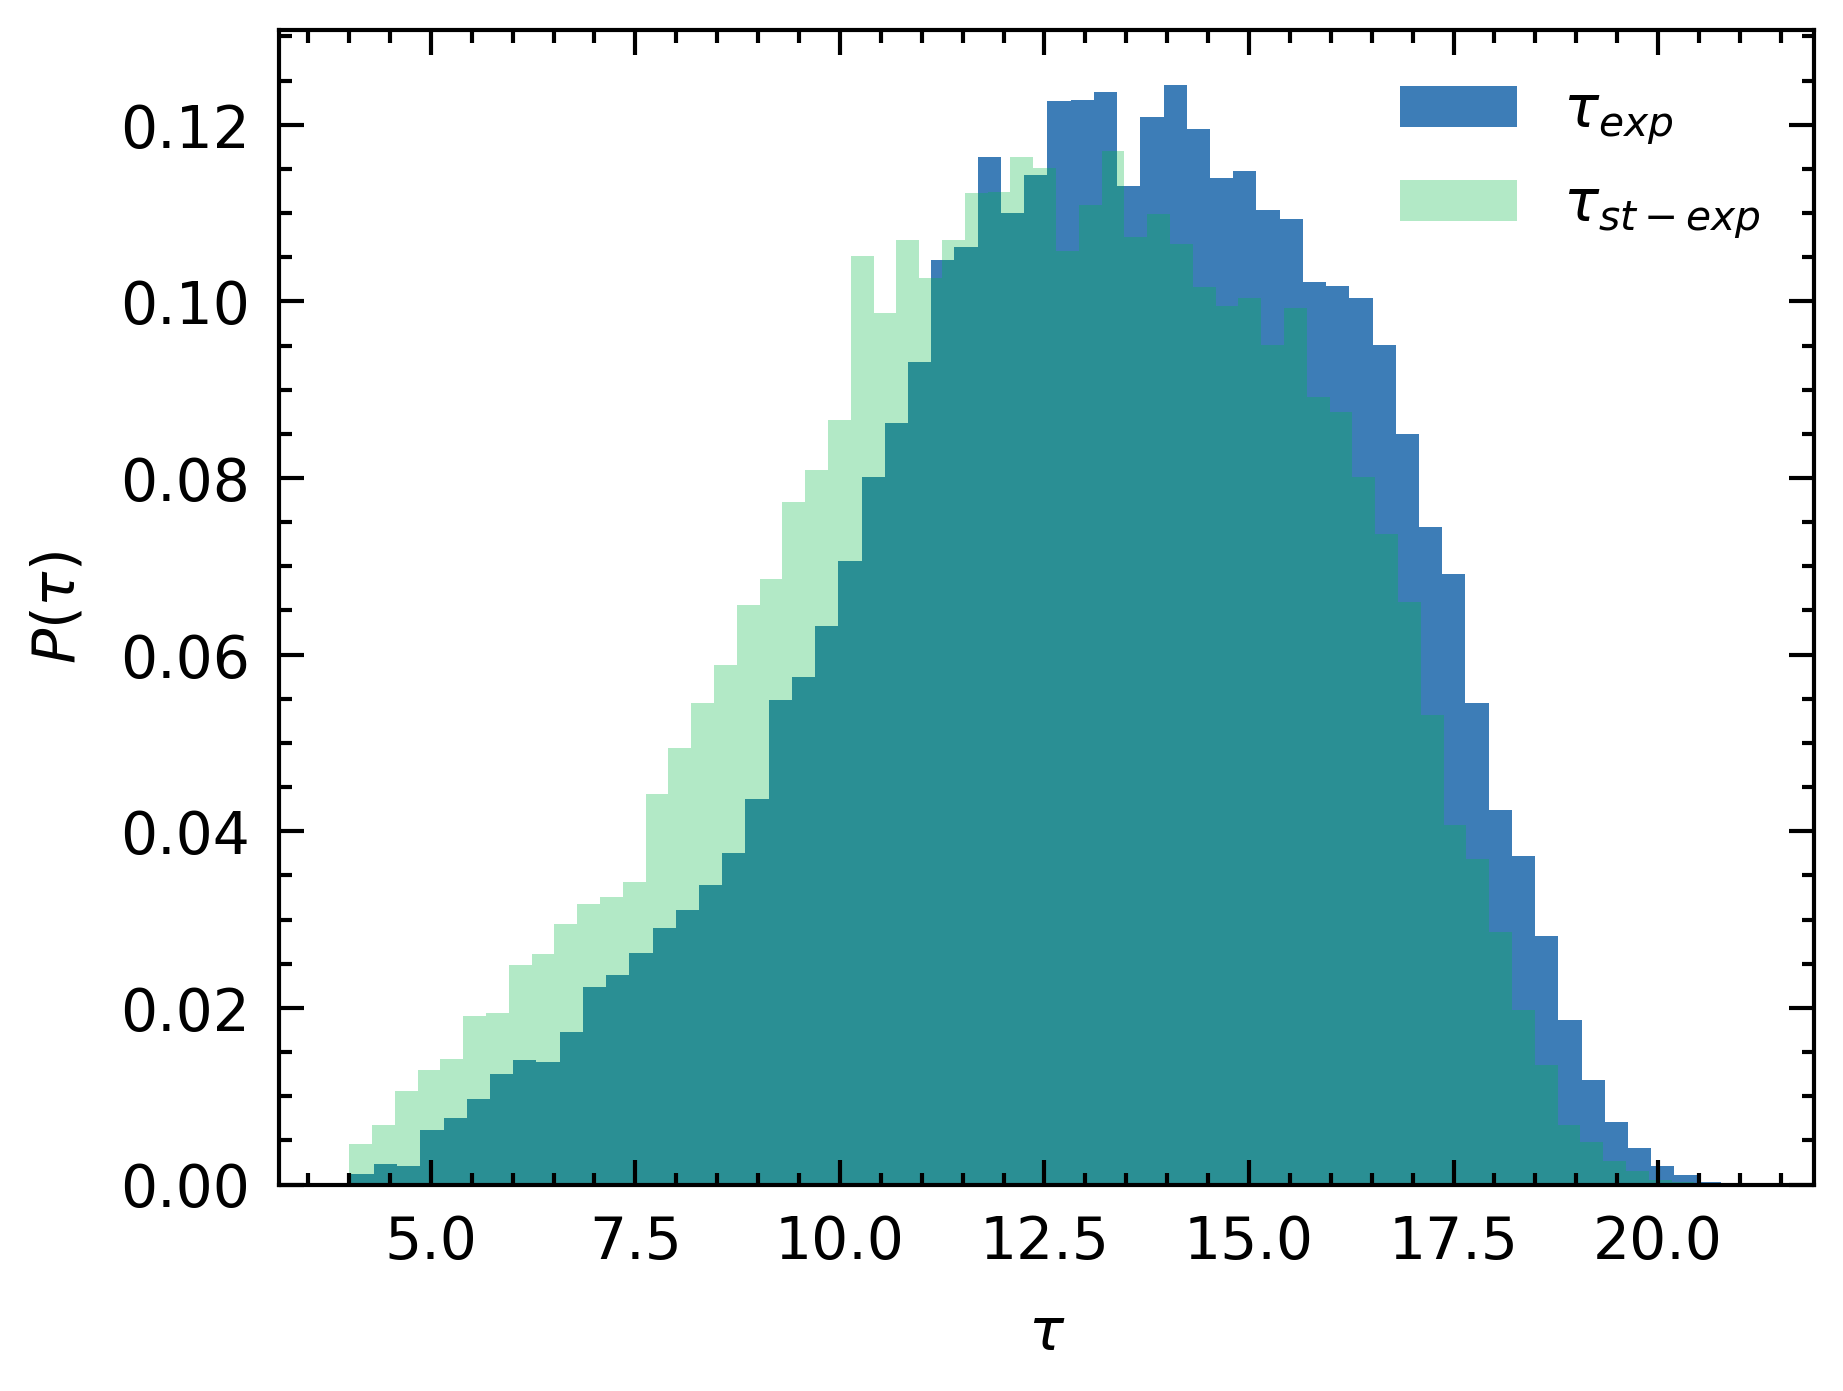

In [37]:
rts_taus_exp_mean = np.nanmean(rts_taus_exp, axis=0)
rts_taus_st_mean = np.nanmean(rts_taus_filt, axis=0)
plt.hist(rts_taus_exp_mean[rts_taus_exp_mean > 4], bins=60, label='$\\tau_{exp}$', alpha=0.8, density=True)
plt.hist(rts_taus_st_mean[rts_taus_st_mean > 4], bins=60, label='$\\tau_{st-exp}$', alpha=0.3, density=True)
plt.xlabel('$\\tau$')
plt.ylabel('$P(\\tau)$')

plt.legend()
plt.savefig('results/plots/taus_dist_exp_large.png')

In [41]:
len(rts_taus_exp_mean[rts_taus_exp_mean < 4])

8

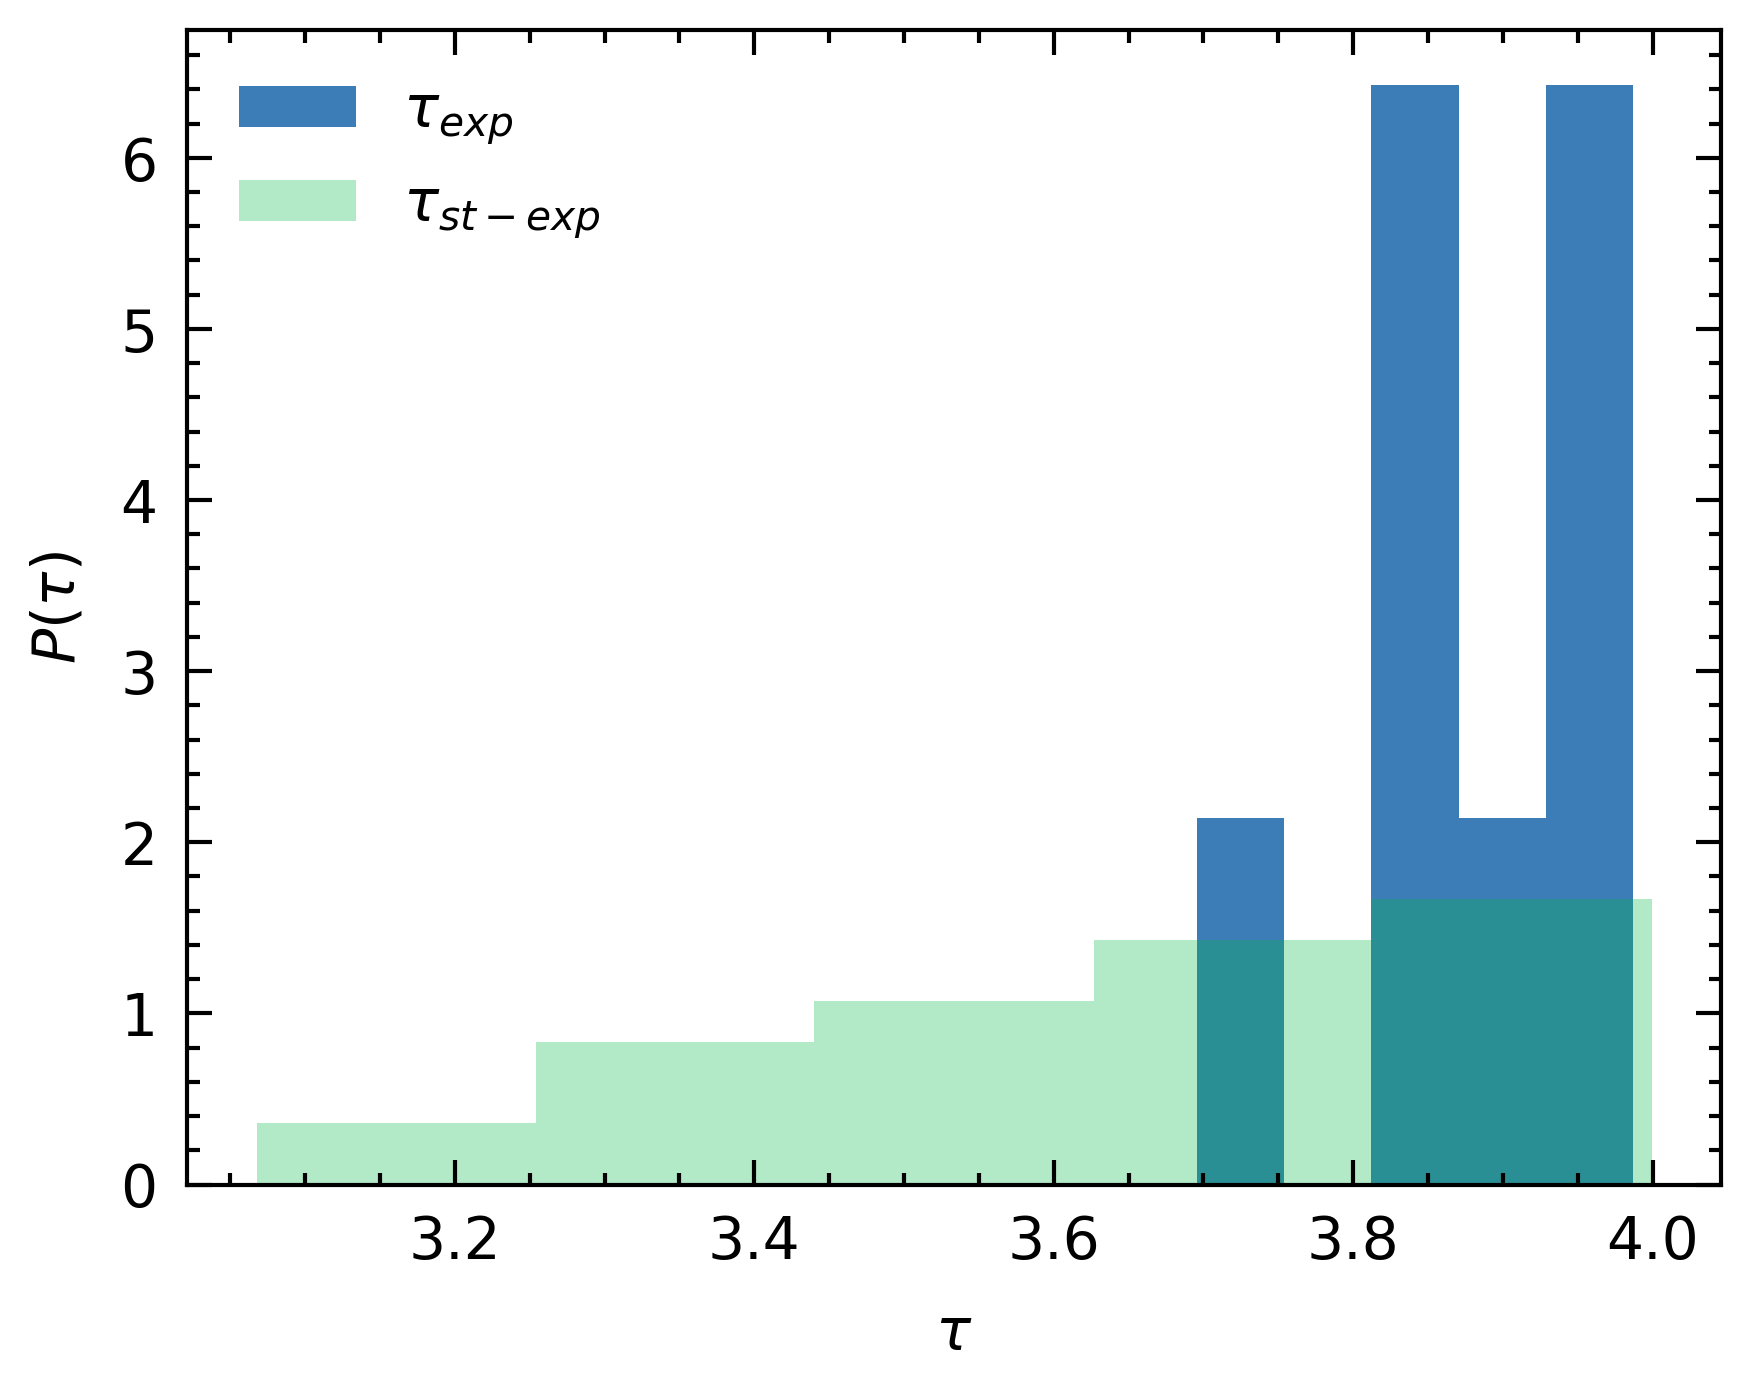

In [40]:
rts_taus_exp_mean = np.nanmean(rts_taus_exp, axis=0)
rts_taus_st_mean = np.nanmean(rts_taus_filt, axis=0)
plt.hist(rts_taus_exp_mean[rts_taus_exp_mean < 4], bins=5, label='$\\tau_{exp}$', alpha=0.8, density=True)
plt.hist(rts_taus_st_mean[rts_taus_st_mean < 4], bins=5, label='$\\tau_{st-exp}$', alpha=0.3, density=True)
plt.xlabel('$\\tau$')
plt.ylabel('$P(\\tau)$')

plt.legend()
plt.savefig('results/plots/taus_dist_exp_small.png')

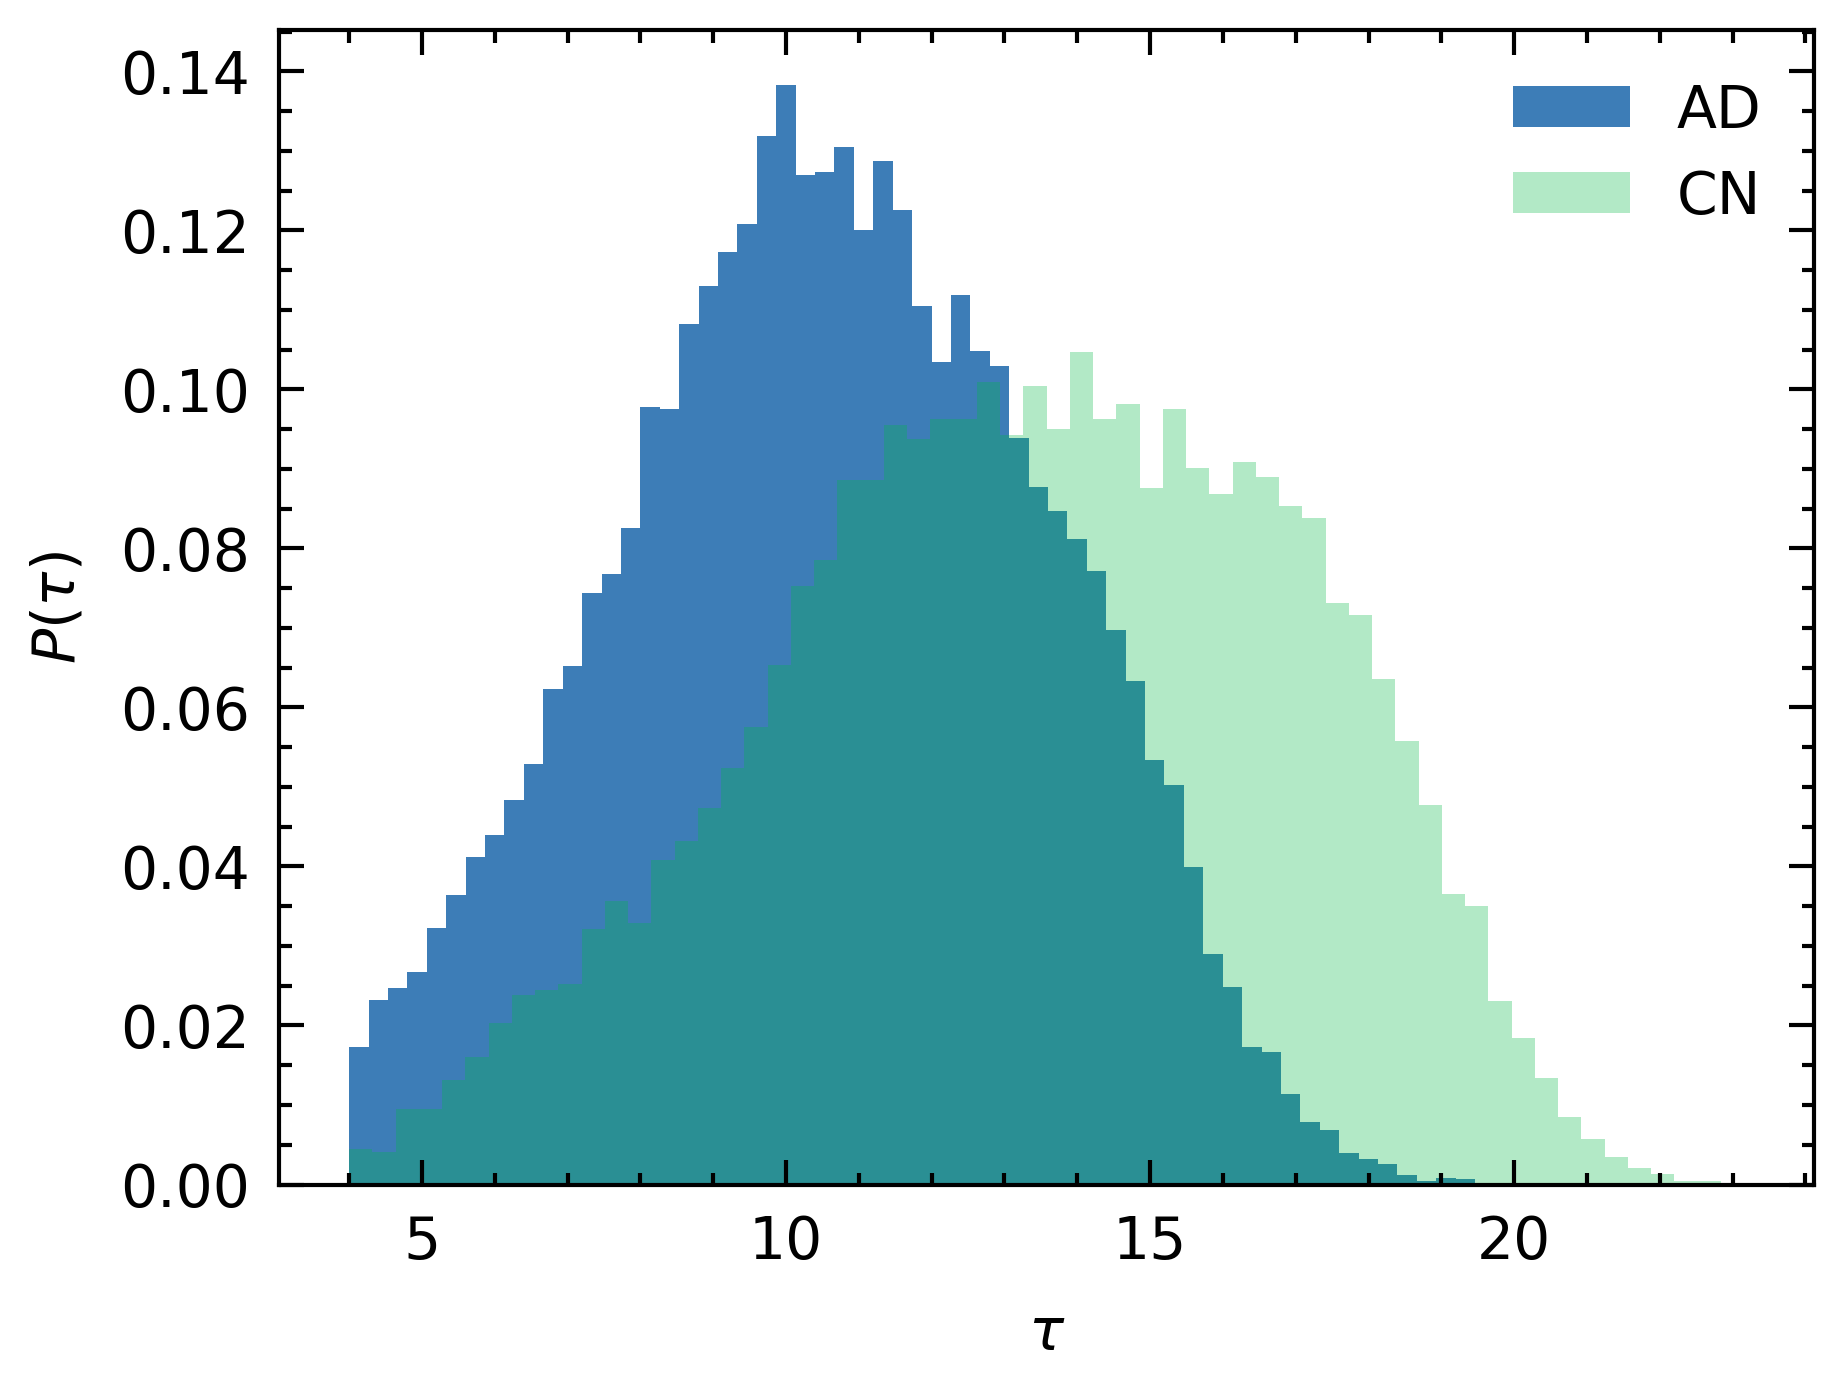

In [47]:
# plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5)
plt.hist(ad_taus_exp_mean[ad_taus_exp_mean > 4], bins=60, label='AD', alpha=0.8, density=True)
plt.hist(cn_taus_exp_mean[cn_taus_exp_mean > 4], bins=60, label='CN', alpha=0.3, density=True)
plt.xlabel('$\\tau$')
plt.ylabel('$P(\\tau)$')

plt.legend()
plt.savefig('results/plots/taus_dist_exp_large.png')

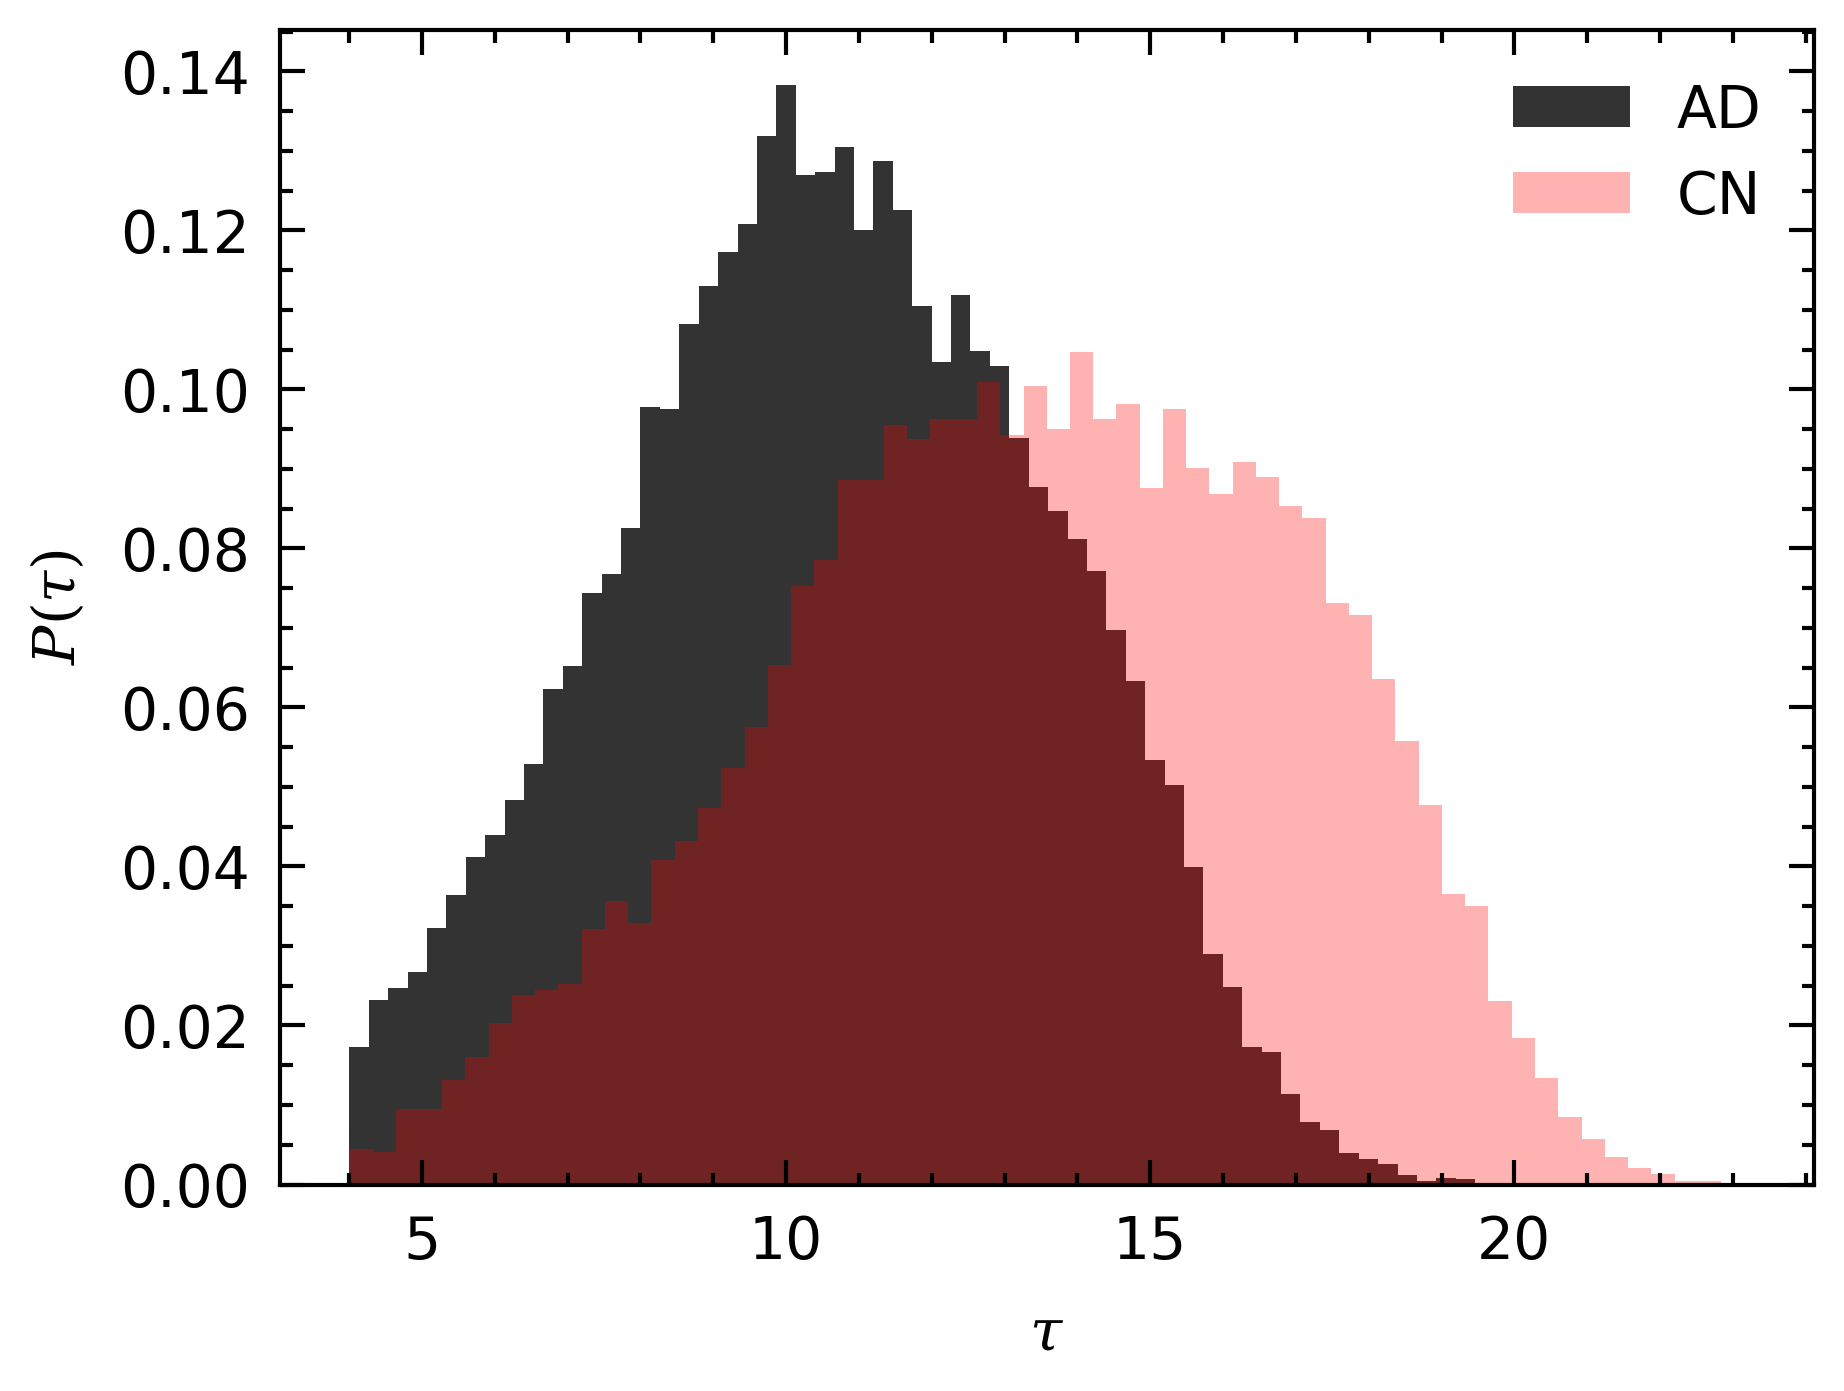

In [66]:
# plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5)
plt.hist(ad_taus_mean[ad_taus_mean > 4], bins=60, label='AD', alpha=0.8, density=True)
plt.hist(cn_taus_mean[cn_taus_mean > 4], bins=60, label='CN', alpha=0.3, density=True)
plt.xlabel('$\\tau$')
plt.ylabel('$P(\\tau)$')

plt.legend()
plt.savefig('results/plots/taus_dist_large.png')

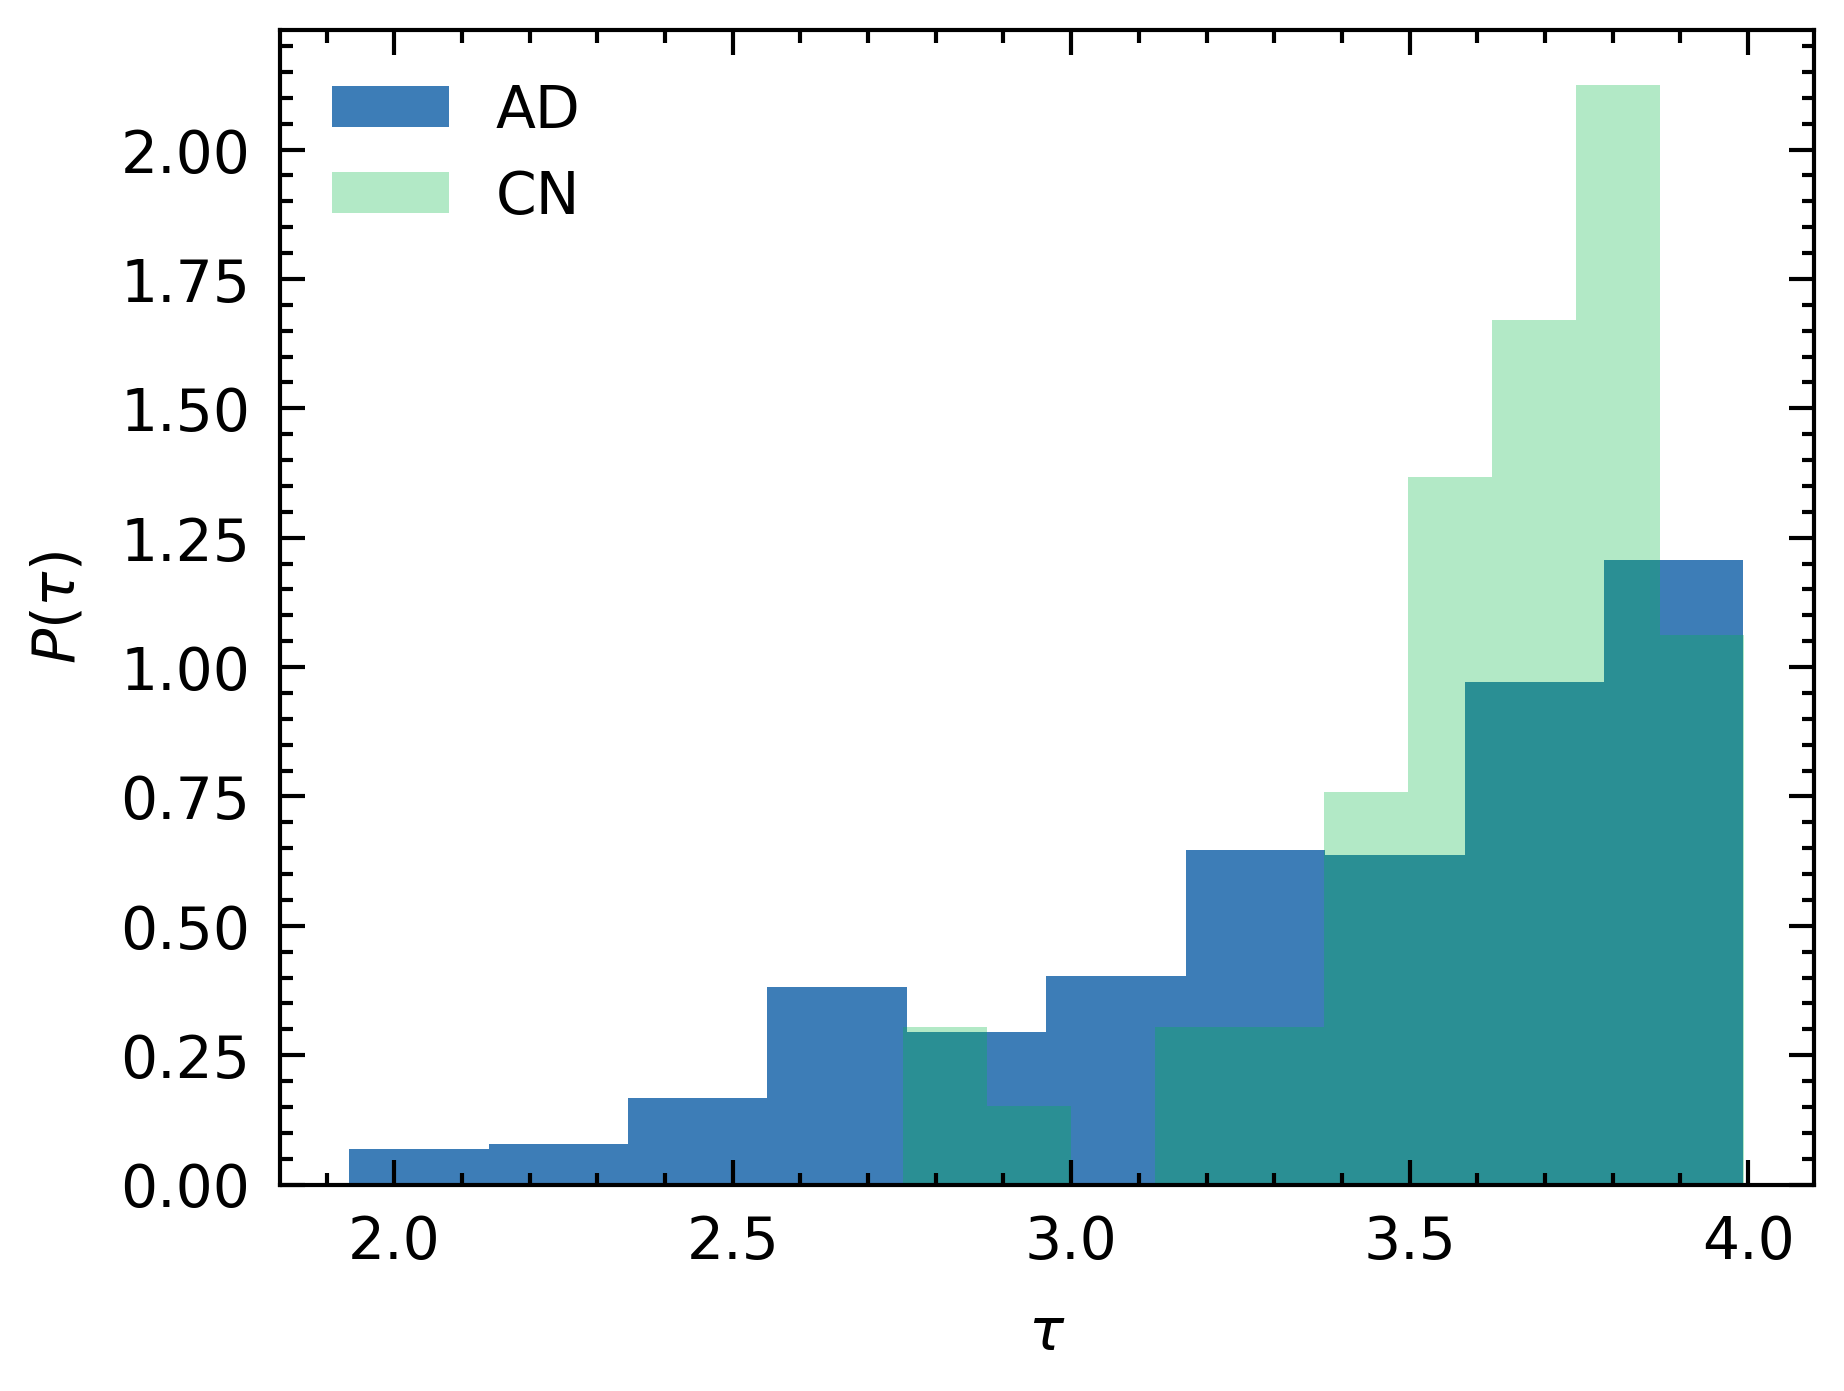

In [49]:
plt.hist(ad_taus_exp_mean[ad_taus_exp_mean < 4], bins=10, label='AD', alpha=0.8, density=True)
plt.hist(cn_taus_exp_mean[cn_taus_exp_mean < 4], bins=10, label='CN', alpha=0.3, density=True)
plt.xlabel('$\\tau$')
plt.ylabel('$P(\\tau)$')

plt.legend()
plt.savefig('results/plots/taus_dist_small.png')

In [93]:
skull_indices = np.load('skull_indices.npy')

In [96]:
(5, 25, 36 ) in skull_indices.T

True

In [100]:
k = np.zeros((2, 7))
print(k)
k[0] = np.nan
k

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


array([[nan, nan, nan, nan, nan, nan, nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])